In [52]:
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings("ignore")

from sklearn.semi_supervised import SelfTrainingClassifier
from joblib import load, dump
from keras.models import load_model, clone_model
from sklearn.metrics import f1_score, accuracy_score, precision_score
from tensorflow.random import set_seed

from copy import deepcopy
import matplotlib.pyplot as plt

import sys
sys.path.append('C:/Users/JoséEmmanuelParedesR/OneDrive - Exitus Credit/Documentos/SCRIPTS/Scripts_Python')
from Funciones_tablas_validacion import *


In [2]:
#sentencias para poner semilla a tensorflow y obtener reproducibilidad con modelos de keras

from tensorflow.random import set_seed
seed_value = 12
set_seed(seed_value)

In [3]:
#funciones para predecir clases y etiquetar en base a las probabilidades de clase que arroja el modelo en cuestion
def predict_clases(modelo, X, clases = (0,1)):
    predictions = modelo.predict(X)
    return [clases[0] if (probas[0] > probas[1]) else clases[1] for probas in predictions]

def retornar_clase_y(y_proba, umbral, clases = (0,1), clase_fail = -1):
    '''Clase para determinar la clase que se le asigna a un registro de la base, de acuerdo a la probabilidad
    que le asigna el modelo.
    Para que se le asigne una clase, la probabilidad de dicha clase debe ser mayor o igual al umbral.'''
    y_clases = []
    lst_proba = [[(num >= umbral) for num in y_proba[i]] for i in range(len(y_proba))]
    for tup in lst_proba:
        if tup[0] == 1 and tup[1] == 0:
            y_clases.append(clases[0])
        elif tup[0] == 0 and tup[1] == 1:
            y_clases.append(clases[1])
        else:
            y_clases.append(clase_fail)
    return y_clases

In [ ]:
#funcion para calificar una base en base a un modelo determinado
def obtener_score(modelo, base, variables):
    '''Función para calificiar al "base" con el "modelo" en cuestion.
    "variables" hace referencia a las variables que usa el modelo para hacer la calificación.'''
    base_output = base.copy()
    X = base_output[variables] ##base sin smote
    #calcular las proba de las predicciones
    try:
        preds = modelo.predict_proba(X) 
    except:
        preds = modelo.predict(X)
    preds = np.array([ preds[i][0] for i in range(len(preds))])
    base_output['score1'] = np.around(preds*1000, decimals = 0)
    return base_output

In [4]:
#obtener lista de variables por segmento
seg_lst = ['S1','S2','S3','S4']
variables = {}
for seg in seg_lst:
    df_var = pd.read_excel('Score_iBillete_Sol20/Variables.xlsx',sheet_name=seg)
    variables = {**variables,**{seg: list(df_var['Variables'].values)}}
    print(seg, len(variables[seg]), 'variables')


S1 31 variables
S2 35 variables
S3 36 variables
S4 28 variables


In [238]:
#se cargan los modelos actuales
model_S1 = load('Score_iBillete_Sol20/MLP_S1.pkl')
model_S2 = load_model('Score_iBillete_Sol20/RNN_S2.h5')
model_S3 = load('Score_iBillete_Sol20/MLP_S3.pkl')
model_S4 = load('Score_iBillete_Sol20/MLP_S4.pkl')

In [239]:
#definir variable target
target = 'BGI'

#cargar bases de entrenamiento, etiquetadas y sin etiquetar
# S1
df_e_S1 = pd.read_csv('Bases_seg_Trainning/Base_Entrenamiento_S1.csv')
df_se_S1 = pd.read_csv('Bases_seg_Trainning/Base_Entrenamiento_sinEtiqueta_S1.csv')
df_se_S1[target] = -1 #indicacion de no etiquetado
# S2
df_e_S2 = pd.read_csv('Bases_seg_Trainning/Base_Entrenamiento_S2.csv')
df_se_S2 = pd.read_csv('Bases_seg_Trainning/Base_Entrenamiento_sinEtiqueta_S2.csv')
df_se_S2[target] = -1
# S3
df_e_S3 = pd.read_csv('Bases_seg_Trainning/Base_Entrenamiento_S3.csv')
df_se_S3 = pd.read_csv('Bases_seg_Trainning/Base_Entrenamiento_sinEtiqueta_S3.csv')
df_se_S3[target] = -1
# S4
df_e_S4 = pd.read_csv('Bases_seg_Trainning/Base_Entrenamiento_S4.csv')
df_se_S4 = pd.read_csv('Bases_seg_Trainning/Base_Entrenamiento_sinEtiqueta_S4.csv')
df_se_S4[target] = -1

In [240]:
#cargar base de comprobación (test)
#S1
df_t_S1 = pd.read_csv('Bases_seg_Trainning/Base_Comprobacion_S1.csv')
#S2
df_t_S2 = pd.read_csv('Bases_seg_Trainning/Base_Comprobacion_S2.csv')
#S3
df_t_S3 = pd.read_csv('Bases_seg_Trainning/Base_Comprobacion_S3.csv')
#S4
df_t_S4 = pd.read_csv('Bases_seg_Trainning/Base_Comprobacion_S4.csv')

In [ ]:
#numero de bandas en las tablas de validación
N=5

#cargar bases para calificar y generar las tablas de validacion
base_S1 = pd.read_csv('Bases_seg_Trainning/Base_Calificar_S1.csv')
base_S2 = pd.read_csv('Bases_seg_Trainning/Base_Calificar_S2.csv')
base_S3 = pd.read_csv('Bases_seg_Trainning/Base_Calificar_S3.csv')
base_S4 = pd.read_csv('Bases_seg_Trainning/Base_Calificar_S4.csv')

In [241]:
#definir el conjunto de train, test y sin etiquetar
#S1
X_train_S1, y_train_S1 = df_e_S1[variables['S1']], df_e_S1[target]
X_se_S1, y_se_S1 = df_se_S1[variables['S1']], df_se_S1[target]
X_test_S1, y_test_S1 = df_t_S1[variables['S1']], df_t_S1[target]
#S2
X_train_S2, y_train_S2 = df_e_S2[variables['S2']], df_e_S2[target]
X_se_S2, y_se_S2 = df_se_S2[variables['S2']], df_se_S2[target]
X_test_S2, y_test_S2 = df_t_S2[variables['S2']], df_t_S2[target]
#S3
X_train_S3, y_train_S3 = df_e_S3[variables['S3']], df_e_S3[target]
X_se_S3, y_se_S3 = df_se_S3[variables['S3']], df_se_S3[target]
X_test_S3, y_test_S3 = df_t_S3[variables['S3']], df_t_S3[target]
#S4
X_train_S4, y_train_S4 = df_e_S4[variables['S4']], df_e_S4[target]
X_se_S4, y_se_S4 = df_se_S4[variables['S4']], df_se_S4[target]
X_test_S4, y_test_S4 = df_t_S4[variables['S4']], df_t_S4[target]

In [ ]:
#se cargan los modelos actuales
model_S1 = load('Score_iBillete_Sol20/MLP_S1.pkl')
#S1
X_train_S1, y_train_S1 = df_e_S1[variables['S1']], df_e_S1[target]
X_se_S1, y_se_S1 = df_se_S1[variables['S1']], df_se_S1[target]
X_test_S1, y_test_S1 = df_t_S1[variables['S1']], df_t_S1[target]

In [253]:
# # umbral = 0.7
# tv = tablas_de_entrenamiento_y_validacion(obtener_score(model_S1, base_S1, variables['S1']), N,  string_score = 'score1', string_bgi = 'BGI')
# KS_train = [tv[0].data['KS'].values[-1]*100] #KS para la tabla de validacion del conjunto train
# KS_test  = [tv[1].data['KS'].values[-1]*100] #KS para la tabla de validacion del conjunto test
# num_sin_etiqueta = len(y_se_S2)
# pseudo_etiquetas = [1]
# iteracion = 1

# while pseudo_etiquetas[-1] > 0:
#     if iteracion == 1:
#         pseudo_etiquetas.pop(0)
        
#     #calcular la probabilidad de las no etiquetadas
#     y_proba_S2 = model_S2.predict(X_se_S2)
#     #obtener la etiqueta (clase) en base a la probabilidad, si ambas probas están debajo del umbral, se asigna -1
#     y_etiquedado_S2 = pd.Series(retornar_clase_y(y_proba_S2, umbral=umbral))
#     #determinar los indices de las que se etiquetaron y se cuentan
#     index_etiquetados = y_etiquedado_S2[y_etiquedado_S2.isin([0,1])].index
#     pseudo_etiquetas.append(len(index_etiquetados)) #contar cuantas se etiquetaron
#     print(f'Iteración #{iteracion}\t Etiquetados: {pseudo_etiquetas[-1]}. Etiquetado total: {sum(pseudo_etiquetas)}/{num_sin_etiqueta}')
#     #agregar los etiquetados al conjunto de entrenamiento
#     X_train_S2 = pd.concat([X_train_S2, X_se_S2.loc[index_etiquetados]]).reset_index(drop=True)
#     y_train_S2 = pd.concat([y_train_S2,y_etiquedado_S2.loc[index_etiquetados]]).reset_index(drop=True)
#     #eliminar los etiquetados del conjunto de no etiquetados
#     X_se_S2 = X_se_S2.drop(index=index_etiquetados).reset_index(drop=True)
#     y_se_S2 = y_se_S2.drop(index=index_etiquetados).reset_index(drop=True)
#     #se reentrena
#     model_S2.fit(X_train_S2, y_train_S2)
#     #agregar al conteo de la iteracion
#     iteracion += 1
    

In [278]:
def reentrenar_modelo(modelo, c_train, c_test, c_se, umbral, n_iter = None):
    
    #hacer una copia profunda de las variables para que no se modifiquen las originales
    model = deepcopy(modelo)
    X_train = c_train[0].copy()
    y_train = c_train[1].copy()
    X_test = c_test[0].copy()
    y_test = c_test[1].copy()
    X_se = c_se[0].copy()
    y_se = c_se[1].copy()
    
    #bandera para saber el valor del umbral
    print('Umbral: ', umbral)
    #comienza el proceso de reentrenamiento
    scores = [f1_score(y_test, modelo.predict(X_test))] #lista para guardar el score. Score del modelo original
    print(f'Score modelo sin reentrenamiento: {scores[-1]:.3f}')
    num_sin_etiqueta = len(y_se)
    pseudo_etiquetas = [-1] #lista para guardar el número de etiquetas en cada iteracion; Se asgina -1 al original
    iteracion = 1

    while pseudo_etiquetas[-1] != 0:         
        #calcular la probabilidad de las no etiquetadas
        y_proba = model.predict_proba(X_se)
        #obtener la etiqueta (clase) en base a la probabilidad, si ambas probas están debajo del umbral, se asigna -1
        y_etiquedado = pd.Series(retornar_clase_y(y_proba, umbral))
        #determinar los indices de las que se etiquetaron y se cuentan
        index_etiquetados = y_etiquedado[y_etiquedado.isin([0,1])].index
        pseudo_etiquetas.append(len(index_etiquetados)) #contar cuantas se etiquetaron
        #agregar los etiquetados al conjunto de entrenamiento
        X_train = pd.concat([X_train, X_se.loc[index_etiquetados]]).reset_index(drop=True)
        y_train = pd.concat([y_train,y_etiquedado.loc[index_etiquetados]]).reset_index(drop=True)
        #eliminar los etiquetados del conjunto de no etiquetados
        X_se = X_se.drop(index=index_etiquetados).reset_index(drop=True)
        y_se = y_se.drop(index=index_etiquetados).reset_index(drop=True)
        #se reentrena
        model.fit(X_train, y_train)
        #calcular el score del modelo
        score = f1_score(y_test, model.predict(X_test))
        scores.append(score)
        #imprimir num etiquetas y score en esta iteracion
        print(f'Iteración #{iteracion}\t Etiquetados: {pseudo_etiquetas[-1]}. Etiquetado total: {sum(pseudo_etiquetas)}/{num_sin_etiqueta}. Score: {score:.3f}')
        #agregar al conteo de la iteracion
        iteracion += 1
        #cortar el proceso si en la primera vuelta se etiqueta a todos
        if X_se.shape[0] == 0:
            break
        #cortar por número de iteraciones
        if n_iter == None:
            pass
        else:
            if iteracion == n_iter+1:
                break
        
    return model, scores, pseudo_etiquetas

def reentrenar_modelo_RN(modelo, c_train, c_test, c_se, umbral, n_iter=None):
    
    #hacer una copia profunda de las variables para que no se modifiquen las originales
    model = clone_model(modelo)
    X_train = c_train[0].copy()
    y_train = c_train[1].copy()
    X_test = c_test[0].copy()
    y_test = c_test[1].copy()
    X_se = c_se[0].copy()
    y_se = c_se[1].copy()
    
    #bandera para saber el valor del umbral
    print('Umbral: ', umbral)
    #comienza el proceso de reentrenamiento
    #blockPrint()
    set_seed(seed_value) #fijar semilla en tensorflow
    scores = [f1_score(y_test, predict_clases(modelo,X_test))] #lista para guardar el score. Score del modelo original
    #enablePrint()
    print(f'Score modelo sin reentrenamiento: {scores[-1]:.3f}')
    num_sin_etiqueta = len(y_se)
    pseudo_etiquetas = [-1] #lista para guardar el número de etiquetas en cada iteracion; Se asgina -1 al original
    iteracion = 1

    while pseudo_etiquetas[-1] != 0:           
        #calcular la probabilidad de las no etiquetadas
        #blockPrint()
        y_proba = model.predict(X_se)
        #enablePrint()
        #obtener la etiqueta (clase) en base a la probabilidad, si ambas probas están debajo del umbral, se asigna -1
        y_etiquedado = pd.Series(retornar_clase_y(y_proba, umbral))
        #determinar los indices de las que se etiquetaron y se cuentan
        index_etiquetados = y_etiquedado[y_etiquedado.isin([0,1])].index
        pseudo_etiquetas.append(len(index_etiquetados)) #contar cuantas se etiquetaron
        #agregar los etiquetados al conjunto de entrenamiento
        X_train = pd.concat([X_train, X_se.loc[index_etiquetados]]).reset_index(drop=True)
        y_train = pd.concat([y_train,y_etiquedado.loc[index_etiquetados]]).reset_index(drop=True)
        #eliminar los etiquetados del conjunto de no etiquetados
        X_se = X_se.drop(index=index_etiquetados).reset_index(drop=True)
        y_se = y_se.drop(index=index_etiquetados).reset_index(drop=True)
        #compilar el modelo
        model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
        #se reentrena
        set_seed(seed_value) #fijar semilla en tensorflow
        model.fit(X_train, y_train, epochs=50, verbose=0)
        #calcular el score del modelo
        score = f1_score(y_test, predict_clases(model,X_test))
        scores.append(score)
         #imprimir num etiquetas y score en esta iteracion
        print(f'Iteración #{iteracion}\t Etiquetados: {pseudo_etiquetas[-1]}. Etiquetado total: {sum(pseudo_etiquetas)}/{num_sin_etiqueta}. Score: {score:.3f}')
        #agregar al conteo de la iteracion
        iteracion += 1
        #cortar el proceso si en la primera vuelta se etiqueta a todos
        if X_se.shape[0] == 0:
            break
        #cortar por número de iteraciones
        if n_iter == None:
            pass
        else:
            if iteracion == n_iter+1:
                break
        
    return model, scores, pseudo_etiquetas

In [279]:
def reentrenar_modelo_KS(modelo, c_train, c_test, c_se, umbral, n_iter = None, num_bandas = 5):
    
    #hacer una copia profunda de las variables para que no se modifiquen las originales
    model = deepcopy(modelo)
    X_train = c_train[0].copy()
    y_train = c_train[1].copy()
    X_se = c_se[0].copy()
    y_se = c_se[1].copy()
    
    #bandera para saber el valor del umbral
    print('Umbral: ', umbral)
    #comienza el proceso de reentrenamiento
    #obetner el KS train y test para el modelo original
    variables_segmento = [var for var in c_test.columns if 'woe' in var]
    tv = tablas_de_entrenamiento_y_validacion(obtener_score(modelo, c_test, variables_segmento), num_bandas,  string_score = 'score1', string_bgi = 'BGI')
    KS_train = [tv[0].data['KS'].values[-1]*100] #lista para guardar los KS train. KS train del modelo original
    KS_test = [tv[1].data['KS'].values[-1]*100] #lista para guardar los KS test. KS test del modelo original
    print(f'KS del modelo sin reentrenamiento. Trian: {KS_train[-1]:.2f}, Test: {KS_test[-1]:.2f}')
    num_sin_etiqueta = len(y_se)
    pseudo_etiquetas = [-1] #lista para guardar el número de etiquetas en cada iteracion; Se asgina -1 al original
    iteracion = 1

    while pseudo_etiquetas[-1] != 0:         
        #calcular la probabilidad de las no etiquetadas
        y_proba = model.predict_proba(X_se)
        #obtener la etiqueta (clase) en base a la probabilidad, si ambas probas están debajo del umbral, se asigna -1
        y_etiquedado = pd.Series(retornar_clase_y(y_proba, umbral))
        #determinar los indices de las que se etiquetaron y se cuentan
        index_etiquetados = y_etiquedado[y_etiquedado.isin([0,1])].index
        pseudo_etiquetas.append(len(index_etiquetados)) #contar cuantas se etiquetaron
        #agregar los etiquetados al conjunto de entrenamiento
        X_train = pd.concat([X_train, X_se.loc[index_etiquetados]]).reset_index(drop=True)
        y_train = pd.concat([y_train,y_etiquedado.loc[index_etiquetados]]).reset_index(drop=True)
        #eliminar los etiquetados del conjunto de no etiquetados
        X_se = X_se.drop(index=index_etiquetados).reset_index(drop=True)
        y_se = y_se.drop(index=index_etiquetados).reset_index(drop=True)
        #se reentrena
        model.fit(X_train, y_train)
        #calcular KS del modelo
        tv = tablas_de_entrenamiento_y_validacion(obtener_score(model, c_test, variables_segmento), num_bandas,  string_score = 'score1', string_bgi = 'BGI')
        ks_train, ks_test = tuple(map(lambda x: x.data['KS'].values[-1]*100, tv))
        KS_train.append(ks_train)
        KS_test.append(ks_test)
        #imprimir num etiquetas y score en esta iteracion
        print(f'Iteración #{iteracion}\t Etiquetados: {pseudo_etiquetas[-1]}. Etiquetado total: {sum(pseudo_etiquetas)}/{num_sin_etiqueta}. KS train: {ks_train:.2f}, KS test: {ks_test:.2f}')
        #agregar al conteo de la iteracion
        iteracion += 1
        #cortar el proceso si en la primera vuelta se etiqueta a todos
        if X_se.shape[0] == 0:
            break
        #cortar por número de iteraciones
        if n_iter == None:
            pass
        else:
            if iteracion == n_iter+1:
                break
        
    return model, KS_train, KS_test, pseudo_etiquetas

def reentrenar_modelo_KS_RN(modelo, c_train, c_test, c_se, umbral, n_iter=None, num_bandas = 5):
    
    #hacer una copia profunda de las variables para que no se modifiquen las originales
    model = clone_model(modelo)
    X_train = c_train[0].copy()
    y_train = c_train[1].copy()
    X_se = c_se[0].copy()
    y_se = c_se[1].copy()
    
     #bandera para saber el valor del umbral
    print('Umbral: ', umbral)
    #comienza el proceso de reentrenamiento
    #obetner el KS train y test para el modelo original
    variables_segmento = [var for var in c_test.columns if 'woe' in var]
    tv = tablas_de_entrenamiento_y_validacion(obtener_score(modelo, c_test, variables_segmento), num_bandas,  string_score = 'score1', string_bgi = 'BGI')
    KS_train = [tv[0].data['KS'].values[-1]*100] #lista para guardar los KS train. KS train del modelo original
    KS_test = [tv[1].data['KS'].values[-1]*100] #lista para guardar los KS test. KS test del modelo original
    print(f'KS del modelo sin reentrenamiento. Trian: {KS_train[-1]:.2f}, Test: {KS_test[-1]:.2f}')
    num_sin_etiqueta = len(y_se)
    pseudo_etiquetas = [-1] #lista para guardar el número de etiquetas en cada iteracion; Se asgina -1 al original
    iteracion = 1

    while pseudo_etiquetas[-1] != 0:           
        #calcular la probabilidad de las no etiquetadas
        #blockPrint()
        y_proba = model.predict(X_se)
        #enablePrint()
        #obtener la etiqueta (clase) en base a la probabilidad, si ambas probas están debajo del umbral, se asigna -1
        y_etiquedado = pd.Series(retornar_clase_y(y_proba, umbral))
        #determinar los indices de las que se etiquetaron y se cuentan
        index_etiquetados = y_etiquedado[y_etiquedado.isin([0,1])].index
        pseudo_etiquetas.append(len(index_etiquetados)) #contar cuantas se etiquetaron
        #agregar los etiquetados al conjunto de entrenamiento
        X_train = pd.concat([X_train, X_se.loc[index_etiquetados]]).reset_index(drop=True)
        y_train = pd.concat([y_train,y_etiquedado.loc[index_etiquetados]]).reset_index(drop=True)
        #eliminar los etiquetados del conjunto de no etiquetados
        X_se = X_se.drop(index=index_etiquetados).reset_index(drop=True)
        y_se = y_se.drop(index=index_etiquetados).reset_index(drop=True)
        #compilar el modelo
        model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
        #se reentrena
        set_seed(seed_value) #fijar semilla en tensorflow
        model.fit(X_train, y_train, epochs=50, verbose=0)
        #calcular KS del modelo
        tv = tablas_de_entrenamiento_y_validacion(obtener_score(model, c_test, variables_segmento), num_bandas,  string_score = 'score1', string_bgi = 'BGI')
        ks_train, ks_test = tuple(map(lambda x: x.data['KS'].values[-1]*100, tv))
        KS_train.append(ks_train)
        KS_test.append(ks_test)
        #imprimir num etiquetas y score en esta iteracion
        print(f'Iteración #{iteracion}\t Etiquetados: {pseudo_etiquetas[-1]}. Etiquetado total: {sum(pseudo_etiquetas)}/{num_sin_etiqueta}. KS train: {ks_train:.2f}, KS test: {ks_test:.2f}')
        #agregar al conteo de la iteracion
        iteracion += 1
        #cortar el proceso si en la primera vuelta se etiqueta a todos
        if X_se.shape[0] == 0:
            break
        #cortar por número de iteraciones
        if n_iter == None:
            pass
        else:
            if iteracion == n_iter+1:
                break
        
    return model, KS_train, KS_test, pseudo_etiquetas

## Determinar los mejores valores de umbral y n_iteraciones para cada segmento

In [286]:
umbral_valores = np.arange(0.50, 1.05, 0.05)
umbral_valores = np.append(umbral_valores, 0.99)
umbral_valores = sorted(umbral_valores)
umbral_valores

[0.5,
 0.55,
 0.6000000000000001,
 0.6500000000000001,
 0.7000000000000002,
 0.7500000000000002,
 0.8000000000000003,
 0.8500000000000003,
 0.9000000000000004,
 0.9500000000000004,
 0.99,
 1.0000000000000004]

### f1 score

In [289]:
umbrales = []
scores_umbral = []
pseudo_etiquetas_umbral = []
   
for umbral in umbral_valores:
    umbrales.append(umbral)
    scores, pseudo_etiquetas = reentrenar_modelo(model_S1, (X_train_S1, y_train_S1), (X_test_S1,y_test_S1), (X_se_S1, y_se_S1), umbral=umbral)[1:]
    scores_umbral.append(scores)
    pseudo_etiquetas_umbral.append(pseudo_etiquetas)

Umbral:  0.5
Score modelo sin reentrenamiento: 0.545
Iteración #1	 Etiquetados: 732. Etiquetado total: 731/732. Score: 0.560
Umbral:  0.55
Score modelo sin reentrenamiento: 0.545
Iteración #1	 Etiquetados: 596. Etiquetado total: 595/732. Score: 0.553
Iteración #2	 Etiquetados: 49. Etiquetado total: 644/732. Score: 0.557
Iteración #3	 Etiquetados: 10. Etiquetado total: 654/732. Score: 0.556
Iteración #4	 Etiquetados: 3. Etiquetado total: 657/732. Score: 0.555
Iteración #5	 Etiquetados: 0. Etiquetado total: 657/732. Score: 0.555
Umbral:  0.6000000000000001
Score modelo sin reentrenamiento: 0.545
Iteración #1	 Etiquetados: 460. Etiquetado total: 459/732. Score: 0.555
Iteración #2	 Etiquetados: 90. Etiquetado total: 549/732. Score: 0.558
Iteración #3	 Etiquetados: 7. Etiquetado total: 556/732. Score: 0.558
Iteración #4	 Etiquetados: 1. Etiquetado total: 557/732. Score: 0.562
Iteración #5	 Etiquetados: 7. Etiquetado total: 564/732. Score: 0.563
Iteración #6	 Etiquetados: 9. Etiquetado total

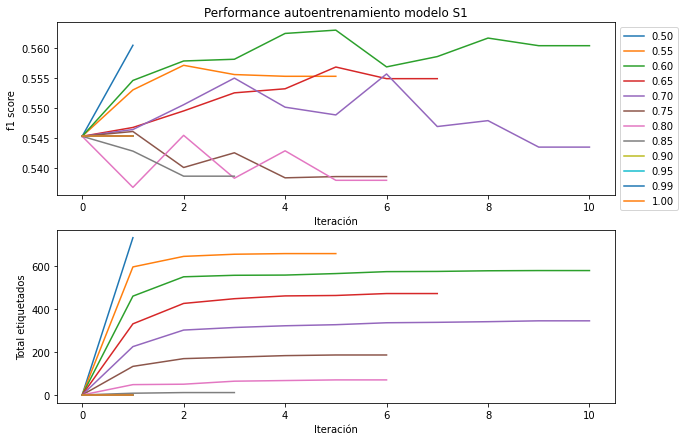

In [290]:
plt.figure(1, figsize=(10,7))
plt.subplot(2,1,1)
for umbral, scores in zip(umbrales, scores_umbral):
    plt.plot(range(len(scores)), scores, label = f'{umbral:.2f}')
plt.xlabel('Iteración')
plt.ylabel('f1 score')
plt.title('Performance autoentrenamiento modelo S1')
plt.legend(bbox_to_anchor=(1,1))

plt.subplot(2,1,2)
for umbral, pseudo_etiquetas in zip(umbrales,pseudo_etiquetas_umbral):
    pseudo_etiquetas_total = [sum(pseudo_etiquetas[:i]) for i in range(1,len(pseudo_etiquetas)+1)]
    plt.plot(range(len(pseudo_etiquetas_total)), pseudo_etiquetas_total, label = f'{umbral:.2f}')
plt.xlabel('Iteración')
plt.ylabel('Total etiquetados')
#plt.title('Etiquetado autoentrenamiento modelo S1')
#plt.legend(bbox_to_anchor=(1,1))
plt.show()

In [291]:
umbrales = []
scores_umbral = []
pseudo_etiquetas_umbral = []
   
for umbral in umbral_valores:
    umbrales.append(umbral)
    scores, pseudo_etiquetas = reentrenar_modelo_RN(model_S2, (X_train_S2, y_train_S2), (X_test_S2,y_test_S2), (X_se_S2, y_se_S2), umbral=umbral)[1:]
    scores_umbral.append(scores)
    pseudo_etiquetas_umbral.append(pseudo_etiquetas)

Umbral:  0.5
22/22 [==============================] - 0s 5ms/step
Score modelo sin reentrenamiento: 0.507
22/22 [==============================] - 0s 5ms/step
Iteración #1	 Etiquetados: 460. Etiquetado total: 459/460. Score: 0.506
Umbral:  0.55
22/22 [==============================] - 0s 5ms/step
Score modelo sin reentrenamiento: 0.507
22/22 [==============================] - 0s 3ms/step
Iteración #1	 Etiquetados: 368. Etiquetado total: 367/460. Score: 0.520
22/22 [==============================] - 0s 5ms/step
Iteración #2	 Etiquetados: 74. Etiquetado total: 441/460. Score: 0.522
22/22 [==============================] - 0s 904us/step
Iteración #3	 Etiquetados: 7. Etiquetado total: 448/460. Score: 0.519
22/22 [==============================] - 0s 871us/step
Iteración #4	 Etiquetados: 8. Etiquetado total: 456/460. Score: 0.519
22/22 [==============================] - 0s 2ms/step
Iteración #5	 Etiquetados: 0. Etiquetado total: 456/460. Score: 0.522
Umbral:  0.6000000000000001
22/22 [=====

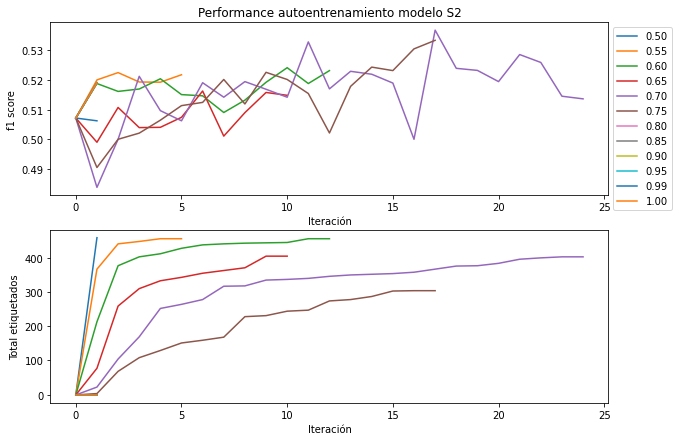

In [292]:
plt.figure(3, figsize=(10,7))
plt.subplot(2,1,1)
for umbral, scores in zip(umbrales, scores_umbral):
    plt.plot(range(len(scores)), scores, label = f'{umbral:.2f}')
plt.xlabel('Iteración')
plt.ylabel('f1 score')
plt.title('Performance autoentrenamiento modelo S2')
plt.legend(bbox_to_anchor=(1,1))

plt.subplot(2,1,2)
for umbral, pseudo_etiquetas in zip(umbrales,pseudo_etiquetas_umbral):
    pseudo_etiquetas_total = [sum(pseudo_etiquetas[:i]) for i in range(1,len(pseudo_etiquetas)+1)]
    plt.plot(range(len(pseudo_etiquetas_total)), pseudo_etiquetas_total, label = f'{umbral:.2f}')
plt.xlabel('Iteración')
plt.ylabel('Total etiquetados')

plt.show()

In [293]:
umbrales = []
scores_umbral = []
pseudo_etiquetas_umbral = []
   
for umbral in umbral_valores:
    umbrales.append(umbral)
    scores, pseudo_etiquetas = reentrenar_modelo(model_S3, (X_train_S3, y_train_S3), (X_test_S3,y_test_S3), (X_se_S3, y_se_S3), umbral=umbral)[1:]
    scores_umbral.append(scores)
    pseudo_etiquetas_umbral.append(pseudo_etiquetas)

Umbral:  0.5
Score modelo sin reentrenamiento: 0.518
Iteración #1	 Etiquetados: 453. Etiquetado total: 452/453. Score: 0.488
Umbral:  0.55
Score modelo sin reentrenamiento: 0.518
Iteración #1	 Etiquetados: 387. Etiquetado total: 386/453. Score: 0.496
Iteración #2	 Etiquetados: 36. Etiquetado total: 422/453. Score: 0.490
Iteración #3	 Etiquetados: 2. Etiquetado total: 424/453. Score: 0.489
Iteración #4	 Etiquetados: 0. Etiquetado total: 424/453. Score: 0.489
Umbral:  0.6000000000000001
Score modelo sin reentrenamiento: 0.518
Iteración #1	 Etiquetados: 339. Etiquetado total: 338/453. Score: 0.495
Iteración #2	 Etiquetados: 42. Etiquetado total: 380/453. Score: 0.490
Iteración #3	 Etiquetados: 7. Etiquetado total: 387/453. Score: 0.491
Iteración #4	 Etiquetados: 0. Etiquetado total: 387/453. Score: 0.491
Umbral:  0.6500000000000001
Score modelo sin reentrenamiento: 0.518
Iteración #1	 Etiquetados: 275. Etiquetado total: 274/453. Score: 0.487
Iteración #2	 Etiquetados: 47. Etiquetado total

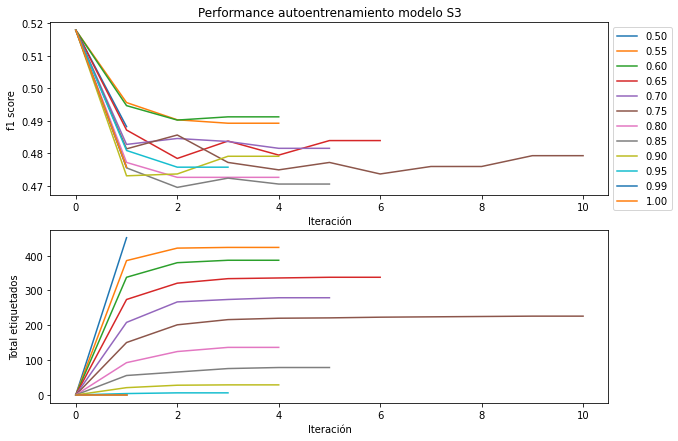

In [294]:
plt.figure(3, figsize=(10,7))
plt.subplot(2,1,1)
for umbral, scores in zip(umbrales, scores_umbral):
    plt.plot(range(len(scores)), scores, label = f'{umbral:.2f}')
plt.xlabel('Iteración')
plt.ylabel('f1 score')
plt.title('Performance autoentrenamiento modelo S3')
plt.legend(bbox_to_anchor=(1,1))

plt.subplot(2,1,2)
for umbral, pseudo_etiquetas in zip(umbrales,pseudo_etiquetas_umbral):
    pseudo_etiquetas_total = [sum(pseudo_etiquetas[:i]) for i in range(1,len(pseudo_etiquetas)+1)]
    plt.plot(range(len(pseudo_etiquetas_total)), pseudo_etiquetas_total, label = f'{umbral:.2f}')
plt.xlabel('Iteración')
plt.ylabel('Total etiquetados')

plt.show()

In [295]:
umbrales = []
scores_umbral = []
pseudo_etiquetas_umbral = []
   
for umbral in umbral_valores:
    umbrales.append(umbral)
    scores, pseudo_etiquetas = reentrenar_modelo(model_S4, (X_train_S4, y_train_S4), (X_test_S4,y_test_S4), (X_se_S4, y_se_S4), umbral=umbral)[1:]
    scores_umbral.append(scores)
    pseudo_etiquetas_umbral.append(pseudo_etiquetas)

Umbral:  0.5
Score modelo sin reentrenamiento: 0.516
Iteración #1	 Etiquetados: 436. Etiquetado total: 435/436. Score: 0.514
Umbral:  0.55
Score modelo sin reentrenamiento: 0.516
Iteración #1	 Etiquetados: 388. Etiquetado total: 387/436. Score: 0.511
Iteración #2	 Etiquetados: 12. Etiquetado total: 399/436. Score: 0.515
Iteración #3	 Etiquetados: 9. Etiquetado total: 408/436. Score: 0.513
Iteración #4	 Etiquetados: 4. Etiquetado total: 412/436. Score: 0.508
Iteración #5	 Etiquetados: 7. Etiquetado total: 419/436. Score: 0.514
Iteración #6	 Etiquetados: 1. Etiquetado total: 420/436. Score: 0.514
Iteración #7	 Etiquetados: 0. Etiquetado total: 420/436. Score: 0.514
Umbral:  0.6000000000000001
Score modelo sin reentrenamiento: 0.516
Iteración #1	 Etiquetados: 322. Etiquetado total: 321/436. Score: 0.520
Iteración #2	 Etiquetados: 31. Etiquetado total: 352/436. Score: 0.523
Iteración #3	 Etiquetados: 19. Etiquetado total: 371/436. Score: 0.512
Iteración #4	 Etiquetados: 2. Etiquetado total

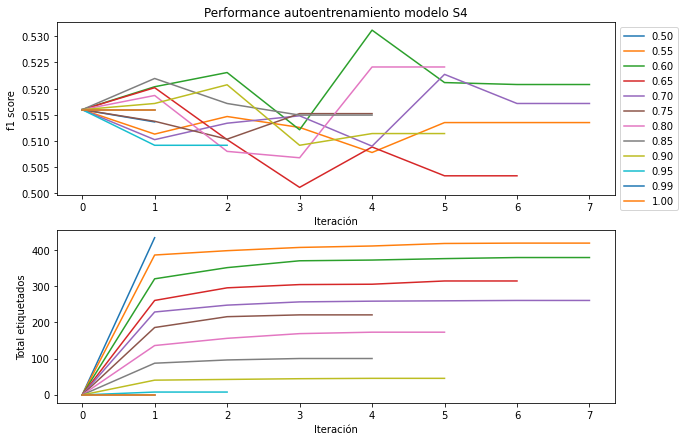

In [296]:
plt.figure(4, figsize=(10,7))
plt.subplot(2,1,1)
for umbral, scores in zip(umbrales, scores_umbral):
    plt.plot(range(len(scores)), scores, label = f'{umbral:.2f}')
plt.xlabel('Iteración')
plt.ylabel('f1 score')
plt.title('Performance autoentrenamiento modelo S4')
plt.legend(bbox_to_anchor=(1,1))

plt.subplot(2,1,2)
for umbral, pseudo_etiquetas in zip(umbrales,pseudo_etiquetas_umbral):
    pseudo_etiquetas_total = [sum(pseudo_etiquetas[:i]) for i in range(1,len(pseudo_etiquetas)+1)]
    plt.plot(range(len(pseudo_etiquetas_total)), pseudo_etiquetas_total, label = f'{umbral:.2f}')
plt.xlabel('Iteración')
plt.ylabel('Total etiquetados')

plt.show()

### KS

In [299]:
umbrales = []
KS_train_umbral = []
KS_test_umbral = []
pseudo_etiquetas_umbral = []
   
for umbral in umbral_valores:
    umbrales.append(umbral)
    ks_train, ks_test, pseudo_etiquetas = reentrenar_modelo_KS(model_S1, (X_train_S1, y_train_S1), base_S1, (X_se_S1, y_se_S1), umbral=umbral)[1:]
    KS_train_umbral.append(ks_train)
    KS_test_umbral.append(ks_test)
    pseudo_etiquetas_umbral.append(pseudo_etiquetas)

Umbral:  0.5
KS del modelo sin reentrenamiento. Trian: 27.11, Test: 26.86
Iteración #1	 Etiquetados: 732. Etiquetado total: 731/732. KS train: 27.21, KS test: 26.27
Umbral:  0.55
KS del modelo sin reentrenamiento. Trian: 27.11, Test: 26.86
Iteración #1	 Etiquetados: 596. Etiquetado total: 595/732. KS train: 27.14, KS test: 26.36
Iteración #2	 Etiquetados: 49. Etiquetado total: 644/732. KS train: 27.38, KS test: 26.91
Iteración #3	 Etiquetados: 10. Etiquetado total: 654/732. KS train: 27.12, KS test: 26.83
Iteración #4	 Etiquetados: 3. Etiquetado total: 657/732. KS train: 27.21, KS test: 26.48
Iteración #5	 Etiquetados: 0. Etiquetado total: 657/732. KS train: 27.21, KS test: 26.48
Umbral:  0.6000000000000001
KS del modelo sin reentrenamiento. Trian: 27.11, Test: 26.86
Iteración #1	 Etiquetados: 460. Etiquetado total: 459/732. KS train: 27.72, KS test: 25.95
Iteración #2	 Etiquetados: 90. Etiquetado total: 549/732. KS train: 27.54, KS test: 26.07
Iteración #3	 Etiquetados: 7. Etiquetado 

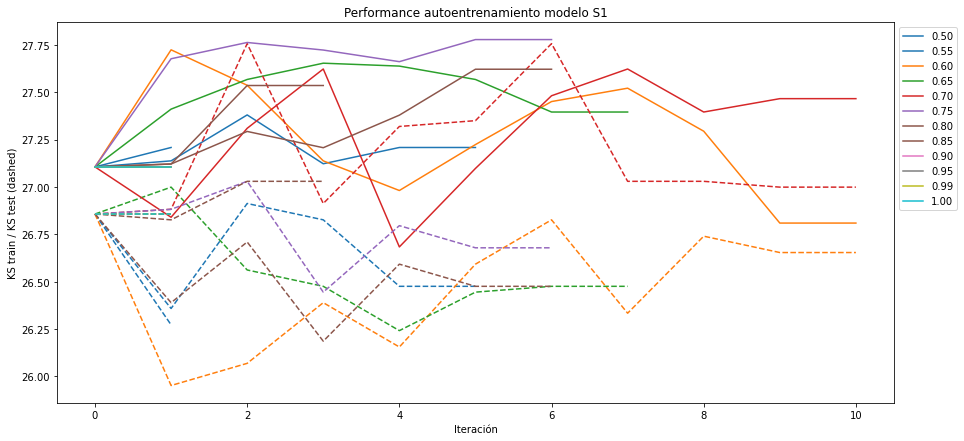

In [329]:
#color
cmap = plt.get_cmap('tab10')
#plot
plt.figure(1, figsize=(15,7))
#plt.subplot(2,1,1)
for umbral, ks_train, ks_test in zip(enumerate(umbrales), KS_train_umbral, KS_test_umbral):
    color = cmap(float(umbral[0])/len(umbrales))
    plt.plot(range(len(ks_train)), ks_train, label = f'{umbral[1]:.2f}', c = color)
    plt.plot(range(len(ks_test)), ks_test, c = color, linestyle = 'dashed')
plt.xlabel('Iteración')
plt.ylabel('KS train / KS test (dashed)')
plt.title('Performance autoentrenamiento modelo S1')
plt.legend(bbox_to_anchor=(1,1))
plt.show()

In [330]:
umbrales = []
KS_train_umbral = []
KS_test_umbral = []
pseudo_etiquetas_umbral = []
   
for umbral in umbral_valores:
    umbrales.append(umbral)
    ks_train, ks_test, pseudo_etiquetas = reentrenar_modelo_KS_RN(model_S2, (X_train_S2, y_train_S2), base_S2, (X_se_S2, y_se_S2), umbral=umbral)[1:]
    KS_train_umbral.append(ks_train)
    KS_test_umbral.append(ks_test)
    pseudo_etiquetas_umbral.append(pseudo_etiquetas)

Umbral:  0.5
53/53 [==============================] - 0s 2ms/step
KS del modelo sin reentrenamiento. Trian: 32.94, Test: 28.12
53/53 [==============================] - 0s 914us/step
Iteración #1	 Etiquetados: 460. Etiquetado total: 459/460. KS train: 30.31, KS test: 29.54
Umbral:  0.55
53/53 [==============================] - 0s 672us/step
KS del modelo sin reentrenamiento. Trian: 32.94, Test: 28.12
53/53 [==============================] - 0s 673us/step
Iteración #1	 Etiquetados: 368. Etiquetado total: 367/460. KS train: 29.28, KS test: 28.14
53/53 [==============================] - 0s 749us/step
Iteración #2	 Etiquetados: 74. Etiquetado total: 441/460. KS train: 32.06, KS test: 28.75
53/53 [==============================] - 0s 774us/step
Iteración #3	 Etiquetados: 7. Etiquetado total: 448/460. KS train: 33.90, KS test: 29.90
53/53 [==============================] - 0s 781us/step
Iteración #4	 Etiquetados: 8. Etiquetado total: 456/460. KS train: 33.57, KS test: 30.40
53/53 [===========

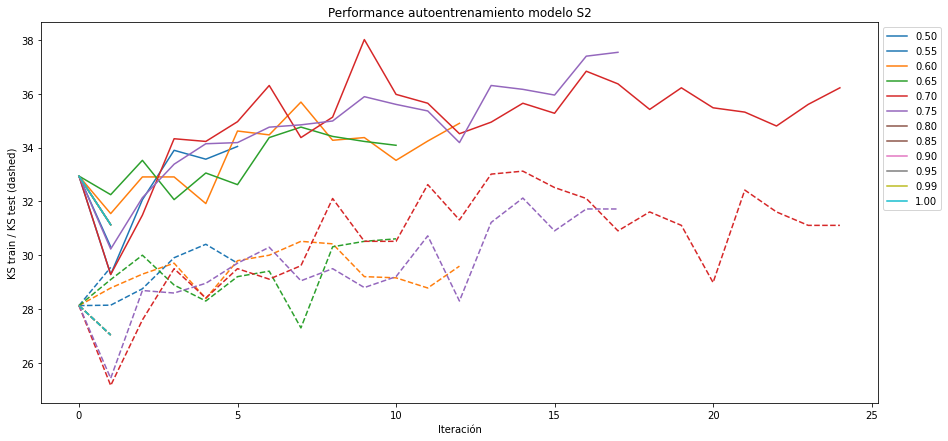

In [331]:
#color
cmap = plt.get_cmap('tab10')
#plot
plt.figure(1, figsize=(15,7))
#plt.subplot(2,1,1)
for umbral, ks_train, ks_test in zip(enumerate(umbrales), KS_train_umbral, KS_test_umbral):
    color = cmap(float(umbral[0])/len(umbrales))
    plt.plot(range(len(ks_train)), ks_train, label = f'{umbral[1]:.2f}', c = color)
    plt.plot(range(len(ks_test)), ks_test, c = color, linestyle = 'dashed')
plt.xlabel('Iteración')
plt.ylabel('KS train / KS test (dashed)')
plt.title('Performance autoentrenamiento modelo S2')
plt.legend(bbox_to_anchor=(1,1))
plt.show()

In [332]:
umbrales = []
KS_train_umbral = []
KS_test_umbral = []
pseudo_etiquetas_umbral = []
   
for umbral in umbral_valores:
    umbrales.append(umbral)
    ks_train, ks_test, pseudo_etiquetas = reentrenar_modelo_KS(model_S3, (X_train_S3, y_train_S3), base_S3, (X_se_S3, y_se_S3), umbral=umbral)[1:]
    KS_train_umbral.append(ks_train)
    KS_test_umbral.append(ks_test)
    pseudo_etiquetas_umbral.append(pseudo_etiquetas)

Umbral:  0.5
KS del modelo sin reentrenamiento. Trian: 38.46, Test: 32.63
Iteración #1	 Etiquetados: 453. Etiquetado total: 452/453. KS train: 39.27, KS test: 29.45
Umbral:  0.55
KS del modelo sin reentrenamiento. Trian: 38.46, Test: 32.63
Iteración #1	 Etiquetados: 387. Etiquetado total: 386/453. KS train: 39.42, KS test: 28.76
Iteración #2	 Etiquetados: 36. Etiquetado total: 422/453. KS train: 40.23, KS test: 29.31
Iteración #3	 Etiquetados: 2. Etiquetado total: 424/453. KS train: 40.87, KS test: 29.11
Iteración #4	 Etiquetados: 0. Etiquetado total: 424/453. KS train: 40.87, KS test: 29.11
Umbral:  0.6000000000000001
KS del modelo sin reentrenamiento. Trian: 38.46, Test: 32.63
Iteración #1	 Etiquetados: 339. Etiquetado total: 338/453. KS train: 40.39, KS test: 27.59
Iteración #2	 Etiquetados: 42. Etiquetado total: 380/453. KS train: 40.23, KS test: 28.69
Iteración #3	 Etiquetados: 7. Etiquetado total: 387/453. KS train: 40.22, KS test: 27.59
Iteración #4	 Etiquetados: 0. Etiquetado t

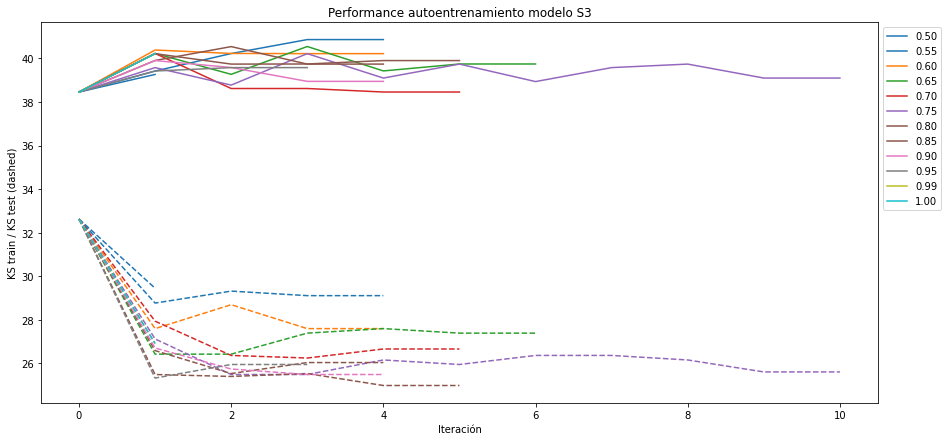

In [333]:
#color
cmap = plt.get_cmap('tab10')
#plot
plt.figure(1, figsize=(15,7))
#plt.subplot(2,1,1)
for umbral, ks_train, ks_test in zip(enumerate(umbrales), KS_train_umbral, KS_test_umbral):
    color = cmap(float(umbral[0])/len(umbrales))
    plt.plot(range(len(ks_train)), ks_train, label = f'{umbral[1]:.2f}', c = color)
    plt.plot(range(len(ks_test)), ks_test, c = color, linestyle = 'dashed')
plt.xlabel('Iteración')
plt.ylabel('KS train / KS test (dashed)')
plt.title('Performance autoentrenamiento modelo S3')
plt.legend(bbox_to_anchor=(1,1))
plt.show()

In [334]:
umbrales = []
KS_train_umbral = []
KS_test_umbral = []
pseudo_etiquetas_umbral = []
   
for umbral in umbral_valores:
    umbrales.append(umbral)
    ks_train, ks_test, pseudo_etiquetas = reentrenar_modelo_KS(model_S4, (X_train_S4, y_train_S4), base_S4, (X_se_S4, y_se_S4), umbral=umbral)[1:]
    KS_train_umbral.append(ks_train)
    KS_test_umbral.append(ks_test)
    pseudo_etiquetas_umbral.append(pseudo_etiquetas)

Umbral:  0.5
KS del modelo sin reentrenamiento. Trian: 39.46, Test: 36.40
Iteración #1	 Etiquetados: 436. Etiquetado total: 435/436. KS train: 39.65, KS test: 36.41
Umbral:  0.55
KS del modelo sin reentrenamiento. Trian: 39.46, Test: 36.40
Iteración #1	 Etiquetados: 388. Etiquetado total: 387/436. KS train: 40.85, KS test: 35.41
Iteración #2	 Etiquetados: 12. Etiquetado total: 399/436. KS train: 41.77, KS test: 36.01
Iteración #3	 Etiquetados: 9. Etiquetado total: 408/436. KS train: 41.77, KS test: 36.61
Iteración #4	 Etiquetados: 4. Etiquetado total: 412/436. KS train: 41.31, KS test: 35.81
Iteración #5	 Etiquetados: 7. Etiquetado total: 419/436. KS train: 42.50, KS test: 36.41
Iteración #6	 Etiquetados: 1. Etiquetado total: 420/436. KS train: 41.31, KS test: 36.61
Iteración #7	 Etiquetados: 0. Etiquetado total: 420/436. KS train: 41.31, KS test: 36.61
Umbral:  0.6000000000000001
KS del modelo sin reentrenamiento. Trian: 39.46, Test: 36.40
Iteración #1	 Etiquetados: 322. Etiquetado to

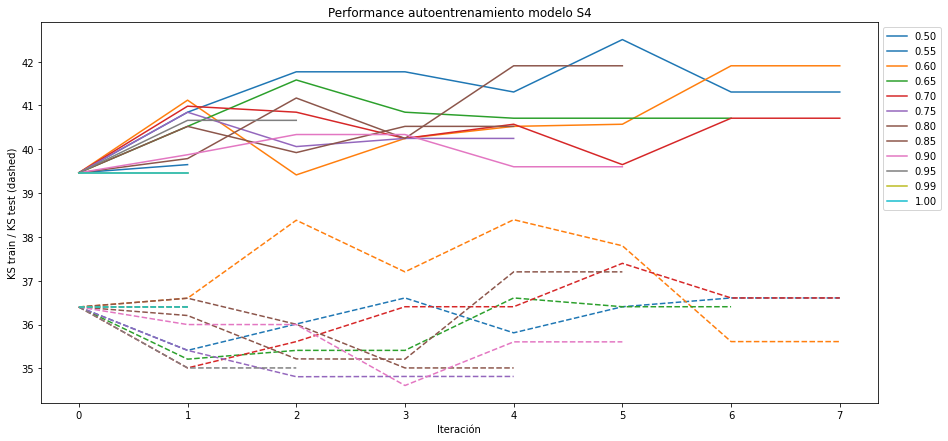

In [335]:
#color
cmap = plt.get_cmap('tab10')
#plot
plt.figure(1, figsize=(15,7))
#plt.subplot(2,1,1)
for umbral, ks_train, ks_test in zip(enumerate(umbrales), KS_train_umbral, KS_test_umbral):
    color = cmap(float(umbral[0])/len(umbrales))
    plt.plot(range(len(ks_train)), ks_train, label = f'{umbral[1]:.2f}', c = color)
    plt.plot(range(len(ks_test)), ks_test, c = color, linestyle = 'dashed')
plt.xlabel('Iteración')
plt.ylabel('KS train / KS test (dashed)')
plt.title('Performance autoentrenamiento modelo S4')
plt.legend(bbox_to_anchor=(1,1))
plt.show()

## Estudio de las tablas de validación

### f1 score

#### S1

In [26]:
st_model_S1 = reentrenar_modelo(model_S1, (X_train_S1, y_train_S1), (X_test_S1,y_test_S1), (X_se_S1, y_se_S1), umbral=0.6, n_iter=5)[0]

Umbral:  0.6
Score modelo sin reentrenamiento: 0.545
Iteración #1	 Etiquetados: 460. Etiquetado total: 459/732. Score: 0.555
Iteración #2	 Etiquetados: 90. Etiquetado total: 549/732. Score: 0.558
Iteración #3	 Etiquetados: 7. Etiquetado total: 556/732. Score: 0.558
Iteración #4	 Etiquetados: 1. Etiquetado total: 557/732. Score: 0.562
Iteración #5	 Etiquetados: 7. Etiquetado total: 564/732. Score: 0.563


In [27]:
st_model_S1_malo = reentrenar_modelo(model_S1, (X_train_S1, y_train_S1), (X_test_S1,y_test_S1), (X_se_S1, y_se_S1), umbral=0.8, n_iter=1)[0]

Umbral:  0.8
Score modelo sin reentrenamiento: 0.545
Iteración #1	 Etiquetados: 48. Etiquetado total: 47/732. Score: 0.537


In [28]:
print('MODELO ORIGINAL')
tv_S1 = tablas_de_entrenamiento_y_validacion(obtener_score(model_S1, base_S1, variables['S1']), N,  string_score = 'score1', string_bgi = 'BGI')
print('train')
display(tv_S1[0])
print('test')
display(tv_S1[1])
print('Calificacion del modelo')
cal_modelo_S1 = calificar_modelo(tv_S1[0], tv_S1[1], dist_malos=0.057, long_bandas=93, KS_min=0.265,dif_KS=0.05,dist_odds=0.3)
display(cal_modelo_S1)

MODELO ORIGINAL
train


,SCORE,TOTAL,%ACUM,BUENOS,%BUENOS,%ACUMBUENOS,MALOS,%MALOS,%ACUMMALOS,TM ACUM,KS,ODDS,GINI
0,675-845,339,100.0%,290,85.5%,100.0%,49,14.5%,100.0%,14.5%,0.0%,5.9,36.2%
1,581-674,380,81.2%,286,75.3%,75.1%,94,24.7%,92.3%,19.9%,17.2%,3.0,35.8%
2,470-580,373,60.1%,237,63.5%,50.5%,136,36.5%,77.6%,25.5%,27.1%,1.7,27.7%
3,349-469,358,39.4%,199,55.6%,30.2%,159,44.4%,56.3%,30.2%,26.2%,1.3,17.4%
4,110-348,353,19.6%,152,43.1%,13.1%,201,56.9%,31.5%,35.4%,18.4%,0.8,6.2%
5,TOTAL,1803,,1164,,,639,35.4%,,,27.1%,,23.3%


test


,SCORE,TOTAL,%ACUM,BUENOS,%BUENOS,%ACUMBUENOS,MALOS,%MALOS,%ACUMMALOS,TM ACUM,KS,ODDS,GINI
0,675-845,288,100.0%,251,87.2%,100.0%,37,12.8%,100.0%,12.8%,0.0%,6.8,41.2%
1,581-674,251,78.6%,175,69.7%,70.6%,76,30.3%,92.5%,21.0%,21.8%,2.3,31.6%
2,470-580,256,60.0%,153,59.8%,50.2%,103,40.2%,77.0%,27.2%,26.9%,1.5,25.3%
3,349-469,274,41.0%,150,54.7%,32.3%,124,45.3%,56.1%,31.8%,23.8%,1.2,17.7%
4,116-348,278,20.6%,126,45.3%,14.7%,152,54.7%,30.9%,36.5%,16.2%,0.8,6.4%
5,TOTAL,1347,,855,,,492,36.5%,,,26.9%,,22.1%


Calificacion del modelo


,1 Ordena,2 Dist. malos 6%,3 Long. bandas 93,4 KS>26%,5 Dif. KS 5%,6 Dist. ODDS 0.30,Calificación
0,1,1,1,1,1,1,
1,1,1,1,,,1,
2,1,1,1,,,1,
3,1,1,1,,,1,
4,,1,1,,,,
5,-,-,-,-,-,-,-
6,1,,1,1,,1,
7,1,,1,,,1,
8,1,,1,,,1,
9,1,,1,,,1,


In [53]:
print('MODELO REENTRENADO CON MEJOR F-SCORE')
tv_st_S1 = tablas_de_entrenamiento_y_validacion(obtener_score(st_model_S1, base_S1, variables['S1']), N,  string_score = 'score1', string_bgi = 'BGI')
print('train')
display(tv_st_S1[0])
print('test')
display(tv_st_S1[1])
print('Calificacion del modelo')
cal_modelo_st_S1 = calificar_modelo(tv_st_S1[0], tv_st_S1[1], dist_malos=0.057, long_bandas=93, KS_min=0.265,dif_KS=0.05,dist_odds=0.3)
display(cal_modelo_st_S1)

MODELO REENTRENADO CON MEJOR F-SCORE
train


,SCORE,TOTAL,%ACUM,BUENOS,%BUENOS,%ACUMBUENOS,MALOS,%MALOS,%ACUMMALOS,TM ACUM,KS,ODDS,GINI
0,717-895,341,100.0%,291,85.3%,100.0%,50,14.7%,100.0%,14.7%,0.0%,5.8,36.3%
1,595-716,380,81.1%,284,74.7%,75.0%,96,25.3%,92.2%,20.2%,17.2%,3.0,35.7%
2,439-594,369,60.0%,241,65.3%,50.6%,128,34.7%,77.2%,25.1%,26.6%,1.9,27.5%
3,260-438,354,39.5%,191,54.0%,29.9%,163,46.0%,57.1%,30.3%,27.2%,1.2,17.4%
4,36-259,359,19.9%,157,43.7%,13.5%,202,56.3%,31.6%,35.4%,18.1%,0.8,6.3%
5,TOTAL,1803,,1164,,,639,35.4%,,,27.2%,,23.2%


test


,SCORE,TOTAL,%ACUM,BUENOS,%BUENOS,%ACUMBUENOS,MALOS,%MALOS,%ACUMMALOS,TM ACUM,KS,ODDS,GINI
0,718-894,286,100.0%,248,86.7%,100.0%,38,13.3%,100.0%,13.3%,0.0%,6.5,40.8%
1,595-715,248,78.8%,174,70.2%,71.0%,74,29.8%,92.3%,21.0%,21.3%,2.4,31.2%
2,439-594,266,60.4%,157,59.0%,50.6%,109,41.0%,77.2%,27.6%,26.6%,1.4,26.1%
3,260-438,275,40.6%,149,54.2%,32.3%,126,45.8%,55.1%,32.3%,22.8%,1.2,17.3%
4,50-259,272,20.2%,127,46.7%,14.9%,145,53.3%,29.5%,36.5%,14.6%,0.9,6.0%
5,TOTAL,1347,,855,,,492,36.5%,,,26.6%,,21.4%


Calificacion del modelo


,1 Ordena,2 Dist. malos 6%,3 Long. bandas 93,4 KS>26%,5 Dif. KS 5%,6 Dist. ODDS 0.30,Calificación
0,1,1,1,1,1,1,
1,1,1,1,,,1,
2,1,0,1,,,1,
3,1,1,1,,,1,
4,,1,1,,,,
5,-,-,-,-,-,-,-
6,1,,1,1,,1,
7,1,,1,,,1,
8,1,,1,,,0,
9,1,,1,,,0,


In [93]:
cal_modelo_st_S1 = calificar_modelo(tv_st_S1[0], tv_st_S1[1], dist_malos=0.09, long_bandas=120, KS_min=0.265,dif_KS=0.05,dist_odds=0.19)
cal_modelo_st_S1

,1 Ordena,2 Dist. malos 9%,3 Long. bandas 120,4 KS>26%,5 Dif. KS 5%,6 Dist. ODDS 0.19,Calificación
0,1,1,1,1,1,1,
1,1,1,1,,,1,
2,1,1,1,,,1,
3,1,1,1,,,1,
4,,1,1,,,,
5,-,-,-,-,-,-,-
6,1,,1,1,,1,
7,1,,1,,,1,
8,1,,1,,,1,
9,1,,1,,,1,


In [84]:
#guardar modelo reentrenado
dump(st_model_S1,'Modelos_reentrenados/st_modelo_S1.pkl')

['Modelos_reentrenados/st_modelo_S1.pkl']

In [98]:
[tv_st_S1[0], tv_st_S1[1], cal_modelo_st_S1]

In [99]:
#guardar tablas de Validación del modelo reentrenado
tables_to_excel([tv_st_S1[0], tv_st_S1[1], cal_modelo_st_S1], ['Train', 'Test', 'Calif.'], 'Modelos_reentrenados/Tablas_Validacion/Tablas_Validacion_st_S1')

In [31]:
print('MODELO REENTRENADO CON PEOR F-SCORE')
tv_st_S1_malo = tablas_de_entrenamiento_y_validacion(obtener_score(st_model_S1_malo, base_S1, variables['S1']), N,  string_score = 'score1', string_bgi = 'BGI')
print('train')
display(tv_st_S1_malo[0])
print('test')
display(tv_st_S1_malo[1])
print('Calificacion del modelo')
cal_modelo_S1 = calificar_modelo(tv_st_S1_malo[0], tv_st_S1_malo[1], dist_malos=0.057, long_bandas=93, KS_min=0.265,dif_KS=0.05,dist_odds=0.3)
display(cal_modelo_S1)

MODELO REENTRENADO CON PEOR F-SCORE
train


,SCORE,TOTAL,%ACUM,BUENOS,%BUENOS,%ACUMBUENOS,MALOS,%MALOS,%ACUMMALOS,TM ACUM,KS,ODDS,GINI
0,675-845,339,100.0%,290,85.5%,100.0%,49,14.5%,100.0%,14.5%,0.0%,5.9,36.2%
1,581-674,383,81.2%,288,75.2%,75.1%,95,24.8%,92.3%,19.9%,17.2%,3.0,36.1%
2,474-580,371,60.0%,238,64.2%,50.3%,133,35.8%,77.5%,25.3%,27.1%,1.8,27.6%
3,356-473,352,39.4%,196,55.7%,29.9%,156,44.3%,56.7%,30.0%,26.8%,1.3,17.4%
4,108-354,358,19.9%,152,42.5%,13.1%,206,57.5%,32.2%,35.4%,19.2%,0.7,6.4%
5,TOTAL,1803,,1164,,,639,35.4%,,,27.1%,,23.6%


test


,SCORE,TOTAL,%ACUM,BUENOS,%BUENOS,%ACUMBUENOS,MALOS,%MALOS,%ACUMMALOS,TM ACUM,KS,ODDS,GINI
0,675-845,288,100.0%,250,86.8%,100.0%,38,13.2%,100.0%,13.2%,0.0%,6.6,41.1%
1,581-674,247,78.6%,172,69.6%,70.8%,75,30.4%,92.3%,21.1%,21.5%,2.3,31.0%
2,474-580,262,60.3%,156,59.5%,50.6%,106,40.5%,77.0%,27.5%,26.4%,1.5,25.8%
3,355-473,275,40.8%,151,54.9%,32.4%,124,45.1%,55.5%,32.0%,23.1%,1.2,17.5%
4,114-354,275,20.4%,126,45.8%,14.7%,149,54.2%,30.3%,36.5%,15.5%,0.8,6.2%
5,TOTAL,1347,,855,,,492,36.5%,,,26.4%,,21.6%


Calificacion del modelo


,1 Ordena,2 Dist. malos 6%,3 Long. bandas 93,4 KS>26%,5 Dif. KS 5%,6 Dist. ODDS 0.30,Calificación
0,1,1,1,1,1,1,
1,1,1,1,,,1,
2,1,1,1,,,1,
3,1,1,1,,,1,
4,,1,1,,,,
5,-,-,-,-,-,-,-
6,1,,1,0,,1,
7,1,,1,,,1,
8,1,,1,,,1,
9,1,,1,,,1,


#### S2

In [32]:
st_model_S2 = reentrenar_modelo_RN(model_S2, (X_train_S2, y_train_S2), (X_test_S2,y_test_S2), (X_se_S2, y_se_S2), umbral=0.7, n_iter=17)[0]

Umbral:  0.7
22/22 [==============================] - 0s 1ms/step
Score modelo sin reentrenamiento: 0.443
22/22 [==============================] - 0s 749us/step
Iteración #1	 Etiquetados: 23. Etiquetado total: 22/460. Score: 0.484
22/22 [==============================] - 0s 571us/step
Iteración #2	 Etiquetados: 82. Etiquetado total: 104/460. Score: 0.500
22/22 [==============================] - 0s 1ms/step
Iteración #3	 Etiquetados: 65. Etiquetado total: 169/460. Score: 0.521
22/22 [==============================] - 0s 742us/step
Iteración #4	 Etiquetados: 83. Etiquetado total: 252/460. Score: 0.510
22/22 [==============================] - 0s 664us/step
Iteración #5	 Etiquetados: 12. Etiquetado total: 264/460. Score: 0.506
22/22 [==============================] - 0s 620us/step
Iteración #6	 Etiquetados: 14. Etiquetado total: 278/460. Score: 0.519
22/22 [==============================] - 0s 690us/step
Iteración #7	 Etiquetados: 39. Etiquetado total: 317/460. Score: 0.514
22/22 [========

In [49]:
print('MODELO ORIGINAL')
tv_S2 = tablas_de_entrenamiento_y_validacion(obtener_score(model_S2, base_S2, variables['S2']), N,  string_score = 'score1', string_bgi = 'BGI')
print('train')
display(tv_S2[0])
print('test')
display(tv_S2[1])
print('Calificacion del modelo')
cal_modelo_S2 = calificar_modelo(tv_S2[0], tv_S2[1], dist_malos=0.075, long_bandas=65, KS_min=0.28,dif_KS=0.05,dist_odds=0.59)
display(cal_modelo_S2)

MODELO ORIGINAL
53/53 [==============================] - 0s 1ms/step
train


,SCORE,TOTAL,%ACUM,BUENOS,%BUENOS,%ACUMBUENOS,MALOS,%MALOS,%ACUMMALOS,TM ACUM,KS,ODDS,GINI
0,711-850,200,100.0%,180,90.0%,100.0%,20,10.0%,100.0%,10.0%,0.0%,9.0,38.7%
1,614-710,221,80.0%,183,82.8%,74.2%,38,17.2%,93.4%,13.8%,19.2%,4.8,38.5%
2,496-613,185,57.9%,127,68.6%,47.9%,58,31.4%,80.9%,19.1%,32.9%,2.2,26.4%
3,332-495,191,39.4%,117,61.3%,29.7%,74,38.7%,61.7%,23.8%,32.0%,1.6,18.9%
4,266-331,203,20.3%,90,44.3%,12.9%,113,55.7%,37.3%,30.3%,24.4%,0.8,7.6%
5,TOTAL,1000,,697,,,303,30.3%,,,32.9%,,30.0%


test


,SCORE,TOTAL,%ACUM,BUENOS,%BUENOS,%ACUMBUENOS,MALOS,%MALOS,%ACUMMALOS,TM ACUM,KS,ODDS,GINI
0,712-850,136,100.0%,120,88.2%,100.0%,16,11.8%,100.0%,11.8%,0.0%,7.5,37.7%
1,614-710,120,80.3%,102,85.0%,75.6%,18,15.0%,92.0%,13.3%,16.4%,5.7,30.3%
2,496-613,150,63.0%,106,70.7%,54.9%,44,29.3%,83.0%,19.2%,28.1%,2.4,31.2%
3,332-495,149,41.3%,93,62.4%,33.3%,56,37.6%,61.0%,24.1%,27.7%,1.7,20.2%
4,266-331,137,19.8%,71,51.8%,14.4%,66,48.2%,33.0%,28.9%,18.6%,1.1,6.5%
5,TOTAL,692,,492,,,200,28.9%,,,28.1%,,26.1%


Calificacion del modelo


,1 Ordena,2 Dist. malos 8%,3 Long. bandas 65,4 KS>28%,5 Dif. KS 5%,6 Dist. ODDS 0.59,Calificación
0,1,1,1,1,1,1,
1,1,1,1,,,1,
2,1,1,1,,,1,
3,1,1,1,,,1,
4,,1,1,,,,
5,-,-,-,-,-,-,-
6,1,,1,1,,1,
7,1,,1,,,1,
8,1,,1,,,1,
9,1,,1,,,1,


In [50]:
print('MODELO REENTRENADO CON MEJOR F-SCORE')
tv_st_S2 = tablas_de_entrenamiento_y_validacion(obtener_score(st_model_S2, base_S2, variables['S2']), N,  string_score = 'score1', string_bgi = 'BGI')
print('train')
display(tv_st_S2[0])
print('test')
display(tv_st_S2[1])
print('Calificacion del modelo')
cal_modelo_S2 = calificar_modelo(tv_st_S2[0], tv_st_S2[1], dist_malos=0.075, long_bandas=65, KS_min=0.28,dif_KS=0.05,dist_odds=0.59)
display(cal_modelo_S2)

MODELO REENTRENADO CON MEJOR F-SCORE
53/53 [==============================] - 0s 786us/step
train


,SCORE,TOTAL,%ACUM,BUENOS,%BUENOS,%ACUMBUENOS,MALOS,%MALOS,%ACUMMALOS,TM ACUM,KS,ODDS,GINI
0,779-943,208,100.0%,193,92.8%,100.0%,15,7.2%,100.0%,7.2%,0.0%,12.9,40.6%
1,600-778,194,79.2%,164,84.5%,72.3%,30,15.5%,95.0%,11.2%,22.7%,5.5,35.0%
2,397-599,195,59.8%,132,67.7%,48.8%,63,32.3%,85.1%,18.1%,36.4%,2.1,29.2%
3,240-395,206,40.3%,122,59.2%,29.8%,84,40.8%,64.4%,23.9%,34.5%,1.5,20.8%
4,51-238,197,19.7%,86,43.7%,12.3%,111,56.3%,36.6%,30.3%,24.3%,0.8,7.2%
5,TOTAL,1000,,697,,,303,30.3%,,,36.4%,,32.7%


test


,SCORE,TOTAL,%ACUM,BUENOS,%BUENOS,%ACUMBUENOS,MALOS,%MALOS,%ACUMMALOS,TM ACUM,KS,ODDS,GINI
0,782-943,130,100.0%,117,90.0%,100.0%,13,10.0%,100.0%,10.0%,0.0%,9.0,36.4%
1,601-778,145,81.2%,119,82.1%,76.2%,26,17.9%,93.5%,14.2%,17.3%,4.6,36.5%
2,396-598,140,60.3%,103,73.6%,52.0%,37,26.4%,80.5%,18.3%,28.5%,2.8,28.8%
3,239-392,135,40.0%,84,62.2%,31.1%,51,37.8%,62.0%,23.1%,30.9%,1.6,19.2%
4,65-237,142,20.5%,69,48.6%,14.0%,73,51.4%,36.5%,28.9%,22.5%,0.9,7.5%
5,TOTAL,692,,492,,,200,28.9%,,,30.9%,,28.3%


Calificacion del modelo


,1 Ordena,2 Dist. malos 8%,3 Long. bandas 65,4 KS>28%,5 Dif. KS 5%,6 Dist. ODDS 0.59,Calificación
0,1,1,1,1,0,1,
1,1,1,1,,,1,
2,1,1,1,,,1,
3,1,1,1,,,1,
4,,1,1,,,,
5,-,-,-,-,-,-,-
6,1,,1,1,,1,
7,1,,1,,,1,
8,1,,1,,,1,
9,1,,1,,,1,


In [104]:
cal_modelo_st_S2 =calificar_modelo(tv_st_S2[0], tv_st_S2[1], dist_malos=0.075, long_bandas=65, KS_min=0.28,dif_KS=0.055,dist_odds=0.59)
cal_modelo_st_S2

,1 Ordena,2 Dist. malos 8%,3 Long. bandas 65,4 KS>28%,5 Dif. KS 6%,6 Dist. ODDS 0.59,Calificación
0,1,1,1,1,1,1,
1,1,1,1,,,1,
2,1,1,1,,,1,
3,1,1,1,,,1,
4,,1,1,,,,
5,-,-,-,-,-,-,-
6,1,,1,1,,1,
7,1,,1,,,1,
8,1,,1,,,1,
9,1,,1,,,1,


In [56]:
#guardar modelo reentrenado
st_model_S2.save('Modelos_reentrenados/st_modelo_S2.h5')

In [105]:
tables_to_excel([tv_st_S2[0], tv_st_S2[1], cal_modelo_st_S2], ['Train', 'Test', 'Calif.'], 'Modelos_reentrenados/Tablas_Validacion/Tablas_Validacion_st_S2')

#### S3

In [ ]:
st_model_S3 = reentrenar_modelo(model_S3, (X_train_S3, y_train_S3), (X_test_S3,y_test_S3), (X_se_S3, y_se_S3), umbral=0.6, n_iter=5)[0]

Umbral:  0.6
Score modelo sin reentrenamiento: 0.545
Iteración #1	 Etiquetados: 460. Etiquetado total: 459/732. Score: 0.555
Iteración #2	 Etiquetados: 90. Etiquetado total: 549/732. Score: 0.558
Iteración #3	 Etiquetados: 7. Etiquetado total: 556/732. Score: 0.558
Iteración #4	 Etiquetados: 1. Etiquetado total: 557/732. Score: 0.562
Iteración #5	 Etiquetados: 7. Etiquetado total: 564/732. Score: 0.563


In [128]:
print('MODELO ORIGINAL')
tv_S3 = tablas_de_entrenamiento_y_validacion(obtener_score(model_S3, base_S3, variables['S3']), N,  string_score = 'score1', string_bgi = 'BGI')
print('train')
display(tv_S3[0])
print('test')
display(tv_S3[1])
print('Calificacion del modelo')
cal_modelo_S3 = calificar_modelo(tv_S3[0], tv_S3[1], dist_malos=0.09, long_bandas=135, KS_min=0.3,dif_KS=0.06,dist_odds=0.29)
display(cal_modelo_S3)

MODELO ORIGINAL
train


,SCORE,TOTAL,%ACUM,BUENOS,%BUENOS,%ACUMBUENOS,MALOS,%MALOS,%ACUMMALOS,TM ACUM,KS,ODDS,GINI
0,785-971,190,100.0%,171,90.0%,100.0%,19,10.0%,100.0%,10.0%,0.0%,9.0,39.5%
1,644-784,179,79.6%,148,82.7%,72.4%,31,17.3%,93.9%,13.6%,21.6%,4.8,34.2%
2,489-642,187,60.5%,130,69.5%,48.5%,57,30.5%,84.1%,19.2%,35.6%,2.3,30.1%
3,321-488,177,40.4%,104,58.8%,27.5%,73,41.2%,65.9%,24.6%,38.5%,1.4,20.6%
4,45-320,200,21.4%,66,33.0%,10.7%,134,67.0%,42.7%,33.7%,32.0%,0.5,9.1%
5,TOTAL,933,,619,,,314,33.7%,,,38.5%,,33.5%


test


,SCORE,TOTAL,%ACUM,BUENOS,%BUENOS,%ACUMBUENOS,MALOS,%MALOS,%ACUMMALOS,TM ACUM,KS,ODDS,GINI
0,785-963,129,100.0%,117,90.7%,100.0%,12,9.3%,100.0%,9.3%,0.0%,9.8,37.6%
1,643-782,139,80.5%,113,81.3%,75.7%,26,18.7%,93.4%,14.2%,17.7%,4.3,36.2%
2,493-642,133,59.6%,104,78.2%,52.2%,29,21.8%,79.1%,16.7%,26.9%,3.6,28.5%
3,321-488,141,39.5%,83,58.9%,30.6%,58,41.1%,63.2%,23.1%,32.6%,1.4,20.1%
4,42-313,121,18.3%,64,52.9%,13.3%,57,47.1%,31.3%,27.5%,18.0%,1.1,5.7%
5,TOTAL,663,,481,,,182,27.5%,,,32.6%,,28.2%


Calificacion del modelo


,1 Ordena,2 Dist. malos 9%,3 Long. bandas 135,4 KS>30%,5 Dif. KS 6%,6 Dist. ODDS 0.29,Calificación
0,1,1,1,1,1,1,
1,1,1,1,,,1,
2,1,1,1,,,1,
3,1,1,1,,,1,
4,,0,1,,,,
5,-,-,-,-,-,-,-
6,1,,1,1,,1,
7,1,,1,,,1,
8,1,,1,,,1,
9,1,,1,,,1,


In [129]:
#guardar tablas de Validación del modelo reentrenado
tables_to_excel([tv_S3[0], tv_S3[1], cal_modelo_S3], ['Train', 'Test', 'Calif.'], 'Modelos_reentrenados/Tablas_Validacion/Tablas_Validacion_S3')

In [ ]:
print('MODELO REENTRENADO CON MEJOR F-SCORE')
tv_st_S1 = tablas_de_entrenamiento_y_validacion(obtener_score(st_model_S1, base_S1, variables['S1']), N,  string_score = 'score1', string_bgi = 'BGI')
print('train')
display(tv_st_S1[0])
print('test')
display(tv_st_S1[1])
print('Calificacion del modelo')
cal_modelo_st_S1 = calificar_modelo(tv_st_S1[0], tv_st_S1[1], dist_malos=0.057, long_bandas=93, KS_min=0.265,dif_KS=0.05,dist_odds=0.3)
display(cal_modelo_st_S1)

In [ ]:
#guardar modelo reentrenado
dump(st_model_S1,'Modelos_reentrenados/st_modelo_S1.pkl')

['Modelos_reentrenados/st_modelo_S1.pkl']

#### S4

In [85]:
st_model_S4 = reentrenar_modelo(model_S4, (X_train_S4, y_train_S4), (X_test_S4,y_test_S4), (X_se_S4, y_se_S4), umbral=0.6, n_iter=4)[0]

Umbral:  0.6
Score modelo sin reentrenamiento: 0.516
Iteración #1	 Etiquetados: 322. Etiquetado total: 321/436. Score: 0.520
Iteración #2	 Etiquetados: 31. Etiquetado total: 352/436. Score: 0.523
Iteración #3	 Etiquetados: 19. Etiquetado total: 371/436. Score: 0.512
Iteración #4	 Etiquetados: 2. Etiquetado total: 373/436. Score: 0.531


In [103]:
print('MODELO ORIGINAL')
tv_S4 = tablas_de_entrenamiento_y_validacion(obtener_score(model_S4, base_S4, variables['S4']), N,  string_score = 'score1', string_bgi = 'BGI')
print('train')
display(tv_S4[0])
print('test')
display(tv_S4[1])
print('Calificacion del modelo')
cal_modelo_S4 = calificar_modelo(tv_S4[0], tv_S4[1], dist_malos=0.06, long_bandas=150, KS_min=0.3,dif_KS=0.05,dist_odds=0.85)
display(cal_modelo_S4)

MODELO ORIGINAL
train


,SCORE,TOTAL,%ACUM,BUENOS,%BUENOS,%ACUMBUENOS,MALOS,%MALOS,%ACUMMALOS,TM ACUM,KS,ODDS,GINI
0,824-975,187,100.0%,180,96.3%,100.0%,7,3.7%,100.0%,3.7%,0.0%,25.7,38.9%
1,668-822,179,80.2%,161,89.9%,75.3%,18,10.1%,96.8%,6.8%,21.5%,8.9,35.1%
2,499-666,200,61.3%,161,80.5%,53.2%,39,19.5%,88.5%,11.3%,35.3%,4.1,33.6%
3,313-496,190,40.1%,126,66.3%,31.0%,64,33.7%,70.5%,16.9%,39.5%,2.0,22.4%
4,27-310,189,20.0%,100,52.9%,13.7%,89,47.1%,41.0%,23.0%,27.3%,1.1,8.2%
5,TOTAL,945,,728,,,217,23.0%,,,39.5%,,38.3%


test


,SCORE,TOTAL,%ACUM,BUENOS,%BUENOS,%ACUMBUENOS,MALOS,%MALOS,%ACUMMALOS,TM ACUM,KS,ODDS,GINI
0,826-976,135,100.0%,122,90.4%,100.0%,13,9.6%,100.0%,9.6%,0.0%,9.4,38.9%
1,667-823,142,79.8%,125,88.0%,75.6%,17,12.0%,92.3%,10.8%,16.7%,7.4,37.1%
2,497-666,123,58.5%,98,79.7%,50.5%,25,20.3%,82.1%,13.8%,31.6%,3.9,27.6%
3,311-496,132,40.0%,88,66.7%,30.9%,44,33.3%,67.3%,18.6%,36.4%,2.0,21.4%
4,47-310,135,20.2%,66,48.9%,13.2%,69,51.1%,41.1%,25.2%,27.8%,1.0,8.3%
5,TOTAL,667,,499,,,168,25.2%,,,36.4%,,33.3%


Calificacion del modelo


,1 Ordena,2 Dist. malos 6%,3 Long. bandas 150,4 KS>30%,5 Dif. KS 5%,6 Dist. ODDS 0.85,Calificación
0,1,1,1,1,1,1,
1,1,1,1,,,1,
2,1,1,1,,,1,
3,1,1,1,,,1,
4,,1,1,,,,
5,-,-,-,-,-,-,-
6,1,,1,1,,1,
7,1,,1,,,1,
8,1,,1,,,1,
9,1,,1,,,1,


In [87]:
print('MODELO REENTRENADO CON MEJOR F-SCORE')
tv_st_S4 = tablas_de_entrenamiento_y_validacion(obtener_score(st_model_S4, base_S4, variables['S4']), N,  string_score = 'score1', string_bgi = 'BGI')
print('train')
display(tv_st_S4[0])
print('test')
display(tv_st_S4[1])
print('Calificacion del modelo')
cal_modelo_st_S4 = calificar_modelo(tv_st_S4[0], tv_st_S4[1], dist_malos=0.06, long_bandas=150, KS_min=0.3,dif_KS=0.05,dist_odds=0.85)
display(cal_modelo_st_S4)

MODELO REENTRENADO CON MEJOR F-SCORE
train


,SCORE,TOTAL,%ACUM,BUENOS,%BUENOS,%ACUMBUENOS,MALOS,%MALOS,%ACUMMALOS,TM ACUM,KS,ODDS,GINI
0,864-993,180,100.0%,173,96.1%,100.0%,7,3.9%,100.0%,3.9%,0.0%,24.7,37.5%
1,702-863,188,81.0%,169,89.9%,76.2%,19,10.1%,96.8%,7.1%,20.5%,8.9,36.8%
2,498-701,197,61.1%,161,81.7%,53.0%,36,18.3%,88.0%,11.0%,35.0%,4.5,33.2%
3,287-497,192,40.2%,126,65.6%,30.9%,66,34.4%,71.4%,16.9%,40.5%,1.9,22.8%
4,20-284,188,19.9%,99,52.7%,13.6%,89,47.3%,41.0%,23.0%,27.4%,1.1,8.2%
5,TOTAL,945,,728,,,217,23.0%,,,40.5%,,38.5%


test


,SCORE,TOTAL,%ACUM,BUENOS,%BUENOS,%ACUMBUENOS,MALOS,%MALOS,%ACUMMALOS,TM ACUM,KS,ODDS,GINI
0,865-990,142,100.0%,129,90.8%,100.0%,13,9.2%,100.0%,9.2%,0.0%,9.9,40.9%
1,705-860,135,78.7%,120,88.9%,74.1%,15,11.1%,92.3%,10.1%,18.1%,8.0,35.5%
2,500-700,125,58.5%,100,80.0%,50.1%,25,20.0%,83.3%,13.2%,33.2%,4.0,28.4%
3,285-497,129,39.7%,88,68.2%,30.1%,41,31.8%,68.5%,17.7%,38.4%,2.1,21.8%
4,23-281,136,20.4%,62,45.6%,12.4%,74,54.4%,44.0%,25.2%,31.6%,0.8,9.0%
5,TOTAL,667,,499,,,168,25.2%,,,38.4%,,35.7%


Calificacion del modelo


,1 Ordena,2 Dist. malos 6%,3 Long. bandas 150,4 KS>30%,5 Dif. KS 5%,6 Dist. ODDS 0.85,Calificación
0,1,1,0,1,1,1,
1,1,1,1,,,1,
2,1,1,1,,,1,
3,1,1,1,,,0,
4,,0,1,,,,
5,-,-,-,-,-,-,-
6,1,,0,1,,1,
7,1,,1,,,1,
8,1,,1,,,1,
9,1,,1,,,1,


In [88]:
calificar_modelo(tv_st_S4[0], tv_st_S4[1], dist_malos=0.071, long_bandas=25, KS_min=0.3,dif_KS=0.05,dist_odds=0.79) #long_bandas=129

,1 Ordena,2 Dist. malos 7%,3 Long. bandas 25,4 KS>30%,5 Dif. KS 5%,6 Dist. ODDS 0.79,Calificación
0,1,1,1,1,1,1,
1,1,1,1,,,1,
2,1,1,1,,,1,
3,1,1,1,,,1,
4,,1,1,,,,
5,-,-,-,-,-,-,-
6,1,,1,1,,1,
7,1,,1,,,1,
8,1,,1,,,1,
9,1,,1,,,1,


In [89]:
#guardar modelo reentrenado
dump(st_model_S4,'Modelos_reentrenados/st_modelo_S4.pkl')

['Modelos_reentrenados/st_modelo_S4.pkl']

In [106]:
tables_to_excel([tv_st_S4[0], tv_st_S4[1], cal_modelo_st_S4], ['Train', 'Test', 'Calif.'], 'Modelos_reentrenados/Tablas_Validacion/Tablas_Validacion_st_S4')

### KS

#### S1

In [336]:
st_model_S1 = reentrenar_modelo_KS(model_S1, (X_train_S1, y_train_S1), base_S1, (X_se_S1, y_se_S1), umbral=0.7, n_iter=6)[0]

Umbral:  0.7
KS del modelo sin reentrenamiento. Trian: 27.11, Test: 26.86
Iteración #1	 Etiquetados: 225. Etiquetado total: 224/732. KS train: 26.84, KS test: 26.88
Iteración #2	 Etiquetados: 77. Etiquetado total: 301/732. KS train: 27.31, KS test: 27.76
Iteración #3	 Etiquetados: 12. Etiquetado total: 313/732. KS train: 27.62, KS test: 26.91
Iteración #4	 Etiquetados: 8. Etiquetado total: 321/732. KS train: 26.68, KS test: 27.32
Iteración #5	 Etiquetados: 5. Etiquetado total: 326/732. KS train: 27.10, KS test: 27.35
Iteración #6	 Etiquetados: 9. Etiquetado total: 335/732. KS train: 27.48, KS test: 27.76


In [337]:
print('MODELO ORIGINAL')
tv_S1 = tablas_de_entrenamiento_y_validacion(obtener_score(model_S1, base_S1, variables['S1']), N,  string_score = 'score1', string_bgi = 'BGI')
print('train')
display(tv_S1[0])
print('test')
display(tv_S1[1])
print('Calificacion del modelo')
cal_modelo_S1 = calificar_modelo(tv_S1[0], tv_S1[1], dist_malos=0.057, long_bandas=93, KS_min=0.265,dif_KS=0.05,dist_odds=0.3)
display(cal_modelo_S1)

MODELO ORIGINAL
train


,SCORE,TOTAL,%ACUM,BUENOS,%BUENOS,%ACUMBUENOS,MALOS,%MALOS,%ACUMMALOS,TM ACUM,KS,ODDS,GINI
0,675-845,339,100.0%,290,85.5%,100.0%,49,14.5%,100.0%,14.5%,0.0%,5.9,36.2%
1,581-674,380,81.2%,286,75.3%,75.1%,94,24.7%,92.3%,19.9%,17.2%,3.0,35.8%
2,470-580,373,60.1%,237,63.5%,50.5%,136,36.5%,77.6%,25.5%,27.1%,1.7,27.7%
3,349-469,358,39.4%,199,55.6%,30.2%,159,44.4%,56.3%,30.2%,26.2%,1.3,17.4%
4,110-348,353,19.6%,152,43.1%,13.1%,201,56.9%,31.5%,35.4%,18.4%,0.8,6.2%
5,TOTAL,1803,,1164,,,639,35.4%,,,27.1%,,23.3%


test


,SCORE,TOTAL,%ACUM,BUENOS,%BUENOS,%ACUMBUENOS,MALOS,%MALOS,%ACUMMALOS,TM ACUM,KS,ODDS,GINI
0,675-845,288,100.0%,251,87.2%,100.0%,37,12.8%,100.0%,12.8%,0.0%,6.8,41.2%
1,581-674,251,78.6%,175,69.7%,70.6%,76,30.3%,92.5%,21.0%,21.8%,2.3,31.6%
2,470-580,256,60.0%,153,59.8%,50.2%,103,40.2%,77.0%,27.2%,26.9%,1.5,25.3%
3,349-469,274,41.0%,150,54.7%,32.3%,124,45.3%,56.1%,31.8%,23.8%,1.2,17.7%
4,116-348,278,20.6%,126,45.3%,14.7%,152,54.7%,30.9%,36.5%,16.2%,0.8,6.4%
5,TOTAL,1347,,855,,,492,36.5%,,,26.9%,,22.1%


Calificacion del modelo


,1 Ordena,2 Dist. malos 6%,3 Long. bandas 93,4 KS>26%,5 Dif. KS 5%,6 Dist. ODDS 0.30,Calificación
0,1,1,1,1,1,1,
1,1,1,1,,,1,
2,1,1,1,,,1,
3,1,1,1,,,1,
4,,1,1,,,,
5,-,-,-,-,-,-,-
6,1,,1,1,,1,
7,1,,1,,,1,
8,1,,1,,,1,
9,1,,1,,,1,


In [338]:
print('MODELO REENTRENADO CON MEJOR F-SCORE')
tv_st_S1 = tablas_de_entrenamiento_y_validacion(obtener_score(st_model_S1, base_S1, variables['S1']), N,  string_score = 'score1', string_bgi = 'BGI')
print('train')
display(tv_st_S1[0])
print('test')
display(tv_st_S1[1])
print('Calificacion del modelo')
cal_modelo_st_S1 = calificar_modelo(tv_st_S1[0], tv_st_S1[1], dist_malos=0.057, long_bandas=93, KS_min=0.265,dif_KS=0.05,dist_odds=0.3)
display(cal_modelo_st_S1)

MODELO REENTRENADO CON MEJOR F-SCORE
train


,SCORE,TOTAL,%ACUM,BUENOS,%BUENOS,%ACUMBUENOS,MALOS,%MALOS,%ACUMMALOS,TM ACUM,KS,ODDS,GINI
0,699-873,346,100.0%,296,85.5%,100.0%,50,14.5%,100.0%,14.5%,0.0%,5.9,36.9%
1,585-698,380,80.8%,284,74.7%,74.6%,96,25.3%,92.2%,20.1%,17.6%,3.0,35.7%
2,452-584,367,59.7%,239,65.1%,50.2%,128,34.9%,77.2%,25.1%,27.0%,1.9,27.3%
3,295-451,353,39.4%,193,54.7%,29.6%,160,45.3%,57.1%,30.0%,27.5%,1.2,17.5%
4,51-294,357,19.8%,152,42.6%,13.1%,205,57.4%,32.1%,35.4%,19.0%,0.7,6.4%
5,TOTAL,1803,,1164,,,639,35.4%,,,27.5%,,23.7%


test


,SCORE,TOTAL,%ACUM,BUENOS,%BUENOS,%ACUMBUENOS,MALOS,%MALOS,%ACUMMALOS,TM ACUM,KS,ODDS,GINI
0,699-873,281,100.0%,245,87.2%,100.0%,36,12.8%,100.0%,12.8%,0.0%,6.8,40.2%
1,585-698,252,79.1%,180,71.4%,71.3%,72,28.6%,92.7%,20.3%,21.3%,2.5,31.9%
2,452-583,264,60.4%,153,58.0%,50.3%,111,42.0%,78.0%,27.5%,27.8%,1.4,26.2%
3,295-451,275,40.8%,150,54.5%,32.4%,125,45.5%,55.5%,32.1%,23.1%,1.2,17.5%
4,62-294,275,20.4%,127,46.2%,14.9%,148,53.8%,30.1%,36.5%,15.2%,0.9,6.1%
5,TOTAL,1347,,855,,,492,36.5%,,,27.8%,,21.9%


Calificacion del modelo


,1 Ordena,2 Dist. malos 6%,3 Long. bandas 93,4 KS>26%,5 Dif. KS 5%,6 Dist. ODDS 0.30,Calificación
0,1,1,1,1,1,1,
1,1,1,1,,,1,
2,1,0,1,,,1,
3,1,1,1,,,1,
4,,1,1,,,,
5,-,-,-,-,-,-,-
6,1,,1,1,,1,
7,1,,1,,,1,
8,1,,1,,,0,
9,1,,1,,,0,


In [351]:
cal_modelo_st_S1 = calificar_modelo(tv_st_S1[0], tv_st_S1[1], dist_malos=0.072, long_bandas=110, KS_min=0.274,dif_KS=0.05,dist_odds=0.19)
cal_modelo_st_S1

,1 Ordena,2 Dist. malos 7%,3 Long. bandas 110,4 KS>27%,5 Dif. KS 5%,6 Dist. ODDS 0.19,Calificación
0,1,1,1,1,1,1,
1,1,1,1,,,1,
2,1,1,1,,,1,
3,1,1,1,,,1,
4,,1,1,,,,
5,-,-,-,-,-,-,-
6,1,,1,1,,1,
7,1,,1,,,1,
8,1,,1,,,1,
9,1,,1,,,1,


In [352]:
#guardar modelo reentrenado
dump(st_model_S1,'Modelos_reentrenados/st_modelo_S1_KS.pkl')

['Modelos_reentrenados/st_modelo_S1_KS.pkl']

In [353]:
#guardar tablas de Validación del modelo reentrenado
tables_to_excel([tv_st_S1[0], tv_st_S1[1], cal_modelo_st_S1], ['Train', 'Test', 'Calif.'], 'Modelos_reentrenados/Tablas_Validacion/Tablas_Validacion_st_S1_KS')

#### S2

In [354]:
st_model_S2 = reentrenar_modelo_KS_RN(model_S2, (X_train_S2, y_train_S2), base_S2, (X_se_S2, y_se_S2), umbral=0.75, n_iter=17)[0]

Umbral:  0.75
53/53 [==============================] - 0s 1ms/step
KS del modelo sin reentrenamiento. Trian: 32.94, Test: 28.12
53/53 [==============================] - 0s 1ms/step
Iteración #1	 Etiquetados: 4. Etiquetado total: 3/460. KS train: 30.23, KS test: 25.42
53/53 [==============================] - 0s 701us/step
Iteración #2	 Etiquetados: 65. Etiquetado total: 68/460. KS train: 32.13, KS test: 28.68
53/53 [==============================] - 0s 1ms/step
Iteración #3	 Etiquetados: 40. Etiquetado total: 108/460. KS train: 33.38, KS test: 28.59
53/53 [==============================] - 0s 861us/step
Iteración #4	 Etiquetados: 21. Etiquetado total: 129/460. KS train: 34.14, KS test: 28.95
53/53 [==============================] - 0s 786us/step
Iteración #5	 Etiquetados: 22. Etiquetado total: 151/460. KS train: 34.18, KS test: 29.70
53/53 [==============================] - 0s 741us/step
Iteración #6	 Etiquetados: 8. Etiquetado total: 159/460. KS train: 34.76, KS test: 30.29
53/53 [====

In [355]:
print('MODELO ORIGINAL')
tv_S2 = tablas_de_entrenamiento_y_validacion(obtener_score(model_S2, base_S2, variables['S2']), N,  string_score = 'score1', string_bgi = 'BGI')
print('train')
display(tv_S2[0])
print('test')
display(tv_S2[1])
print('Calificacion del modelo')
cal_modelo_S2 = calificar_modelo(tv_S2[0], tv_S2[1], dist_malos=0.075, long_bandas=65, KS_min=0.28,dif_KS=0.05,dist_odds=0.59)
display(cal_modelo_S2)

MODELO ORIGINAL
53/53 [==============================] - 0s 2ms/step
train


,SCORE,TOTAL,%ACUM,BUENOS,%BUENOS,%ACUMBUENOS,MALOS,%MALOS,%ACUMMALOS,TM ACUM,KS,ODDS,GINI
0,711-850,200,100.0%,180,90.0%,100.0%,20,10.0%,100.0%,10.0%,0.0%,9.0,38.7%
1,614-710,221,80.0%,183,82.8%,74.2%,38,17.2%,93.4%,13.8%,19.2%,4.8,38.5%
2,496-613,185,57.9%,127,68.6%,47.9%,58,31.4%,80.9%,19.1%,32.9%,2.2,26.4%
3,332-495,191,39.4%,117,61.3%,29.7%,74,38.7%,61.7%,23.8%,32.0%,1.6,18.9%
4,266-331,203,20.3%,90,44.3%,12.9%,113,55.7%,37.3%,30.3%,24.4%,0.8,7.6%
5,TOTAL,1000,,697,,,303,30.3%,,,32.9%,,30.0%


test


,SCORE,TOTAL,%ACUM,BUENOS,%BUENOS,%ACUMBUENOS,MALOS,%MALOS,%ACUMMALOS,TM ACUM,KS,ODDS,GINI
0,712-850,136,100.0%,120,88.2%,100.0%,16,11.8%,100.0%,11.8%,0.0%,7.5,37.7%
1,614-710,120,80.3%,102,85.0%,75.6%,18,15.0%,92.0%,13.3%,16.4%,5.7,30.3%
2,496-613,150,63.0%,106,70.7%,54.9%,44,29.3%,83.0%,19.2%,28.1%,2.4,31.2%
3,332-495,149,41.3%,93,62.4%,33.3%,56,37.6%,61.0%,24.1%,27.7%,1.7,20.2%
4,266-331,137,19.8%,71,51.8%,14.4%,66,48.2%,33.0%,28.9%,18.6%,1.1,6.5%
5,TOTAL,692,,492,,,200,28.9%,,,28.1%,,26.1%


Calificacion del modelo


,1 Ordena,2 Dist. malos 8%,3 Long. bandas 65,4 KS>28%,5 Dif. KS 5%,6 Dist. ODDS 0.59,Calificación
0,1,1,1,1,1,1,
1,1,1,1,,,1,
2,1,1,1,,,1,
3,1,1,1,,,1,
4,,1,1,,,,
5,-,-,-,-,-,-,-
6,1,,1,1,,1,
7,1,,1,,,1,
8,1,,1,,,1,
9,1,,1,,,1,


In [356]:
print('MODELO REENTRENADO CON MEJOR F-SCORE')
tv_st_S2 = tablas_de_entrenamiento_y_validacion(obtener_score(st_model_S2, base_S2, variables['S2']), N,  string_score = 'score1', string_bgi = 'BGI')
print('train')
display(tv_st_S2[0])
print('test')
display(tv_st_S2[1])
print('Calificacion del modelo')
cal_modelo_S2 = calificar_modelo(tv_st_S2[0], tv_st_S2[1], dist_malos=0.075, long_bandas=65, KS_min=0.28,dif_KS=0.05,dist_odds=0.59)
display(cal_modelo_S2)

MODELO REENTRENADO CON MEJOR F-SCORE
53/53 [==============================] - 0s 1ms/step
train


,SCORE,TOTAL,%ACUM,BUENOS,%BUENOS,%ACUMBUENOS,MALOS,%MALOS,%ACUMMALOS,TM ACUM,KS,ODDS,GINI
0,806-926,207,100.0%,191,92.3%,100.0%,16,7.7%,100.0%,7.7%,0.0%,11.9,40.3%
1,658-805,195,79.3%,162,83.1%,72.6%,33,16.9%,94.7%,12.2%,22.1%,4.9,34.8%
2,442-657,193,59.8%,141,73.1%,49.4%,52,26.9%,83.8%,17.0%,34.5%,2.7,29.0%
3,231-441,209,40.5%,119,56.9%,29.1%,90,43.1%,66.7%,23.8%,37.5%,1.3,21.7%
4,18-230,196,19.6%,84,42.9%,12.1%,112,57.1%,37.0%,30.3%,24.9%,0.8,7.2%
5,TOTAL,1000,,697,,,303,30.3%,,,37.5%,,33.1%


test


,SCORE,TOTAL,%ACUM,BUENOS,%BUENOS,%ACUMBUENOS,MALOS,%MALOS,%ACUMMALOS,TM ACUM,KS,ODDS,GINI
0,806-929,132,100.0%,120,90.9%,100.0%,12,9.1%,100.0%,9.1%,0.0%,10.0,37.0%
1,658-802,141,80.9%,113,80.1%,75.6%,28,19.9%,94.0%,14.7%,18.4%,4.0,35.5%
2,442-657,146,60.5%,110,75.3%,52.6%,36,24.7%,80.0%,18.1%,27.4%,3.1,30.0%
3,237-441,130,39.5%,77,59.2%,30.3%,53,40.8%,62.0%,23.5%,31.7%,1.5,18.3%
4,30-228,143,20.7%,72,50.3%,14.6%,71,49.7%,35.5%,28.9%,20.9%,1.0,7.3%
5,TOTAL,692,,492,,,200,28.9%,,,31.7%,,28.1%


Calificacion del modelo


,1 Ordena,2 Dist. malos 8%,3 Long. bandas 65,4 KS>28%,5 Dif. KS 5%,6 Dist. ODDS 0.59,Calificación
0,1,1,1,1,0,1,
1,1,1,1,,,1,
2,1,1,1,,,1,
3,1,1,1,,,0,
4,,1,1,,,,
5,-,-,-,-,-,-,-
6,1,,1,1,,1,
7,1,,1,,,1,
8,1,,1,,,1,
9,1,,1,,,0,


In [366]:
cal_modelo_st_S2 =calificar_modelo(tv_st_S2[0], tv_st_S2[1], dist_malos=0.075, long_bandas=120, KS_min=0.3,dif_KS=0.06,dist_odds=0.5)
cal_modelo_st_S2

,1 Ordena,2 Dist. malos 8%,3 Long. bandas 120,4 KS>30%,5 Dif. KS 6%,6 Dist. ODDS 0.50,Calificación
0,1,1,1,1,1,1,
1,1,1,1,,,1,
2,1,1,1,,,1,
3,1,1,1,,,1,
4,,1,1,,,,
5,-,-,-,-,-,-,-
6,1,,1,1,,1,
7,1,,1,,,1,
8,1,,1,,,1,
9,1,,1,,,1,


In [367]:
#guardar modelo reentrenado
st_model_S2.save('Modelos_reentrenados/st_modelo_S2_KS.h5')

In [368]:
tables_to_excel([tv_st_S2[0], tv_st_S2[1], cal_modelo_st_S2], ['Train', 'Test', 'Calif.'], 'Modelos_reentrenados/Tablas_Validacion/Tablas_Validacion_st_S2_KS')

#### S3

In [369]:
st_model_S3 = reentrenar_modelo_KS(model_S3, (X_train_S3, y_train_S3), base_S3, (X_se_S3, y_se_S3), umbral=0.5, n_iter=1)[0]

Umbral:  0.5
KS del modelo sin reentrenamiento. Trian: 38.46, Test: 32.63
Iteración #1	 Etiquetados: 453. Etiquetado total: 452/453. KS train: 39.27, KS test: 29.45


In [370]:
print('MODELO ORIGINAL')
tv_S3 = tablas_de_entrenamiento_y_validacion(obtener_score(model_S3, base_S3, variables['S3']), N,  string_score = 'score1', string_bgi = 'BGI')
print('train')
display(tv_S3[0])
print('test')
display(tv_S3[1])
print('Calificacion del modelo')
cal_modelo_S3 = calificar_modelo(tv_S3[0], tv_S3[1], dist_malos=0.09, long_bandas=135, KS_min=0.3,dif_KS=0.06,dist_odds=0.29)
display(cal_modelo_S3)

MODELO ORIGINAL
train


,SCORE,TOTAL,%ACUM,BUENOS,%BUENOS,%ACUMBUENOS,MALOS,%MALOS,%ACUMMALOS,TM ACUM,KS,ODDS,GINI
0,785-971,190,100.0%,171,90.0%,100.0%,19,10.0%,100.0%,10.0%,0.0%,9.0,39.5%
1,644-784,179,79.6%,148,82.7%,72.4%,31,17.3%,93.9%,13.6%,21.6%,4.8,34.2%
2,489-642,187,60.5%,130,69.5%,48.5%,57,30.5%,84.1%,19.2%,35.6%,2.3,30.1%
3,321-488,177,40.4%,104,58.8%,27.5%,73,41.2%,65.9%,24.6%,38.5%,1.4,20.6%
4,45-320,200,21.4%,66,33.0%,10.7%,134,67.0%,42.7%,33.7%,32.0%,0.5,9.1%
5,TOTAL,933,,619,,,314,33.7%,,,38.5%,,33.5%


test


,SCORE,TOTAL,%ACUM,BUENOS,%BUENOS,%ACUMBUENOS,MALOS,%MALOS,%ACUMMALOS,TM ACUM,KS,ODDS,GINI
0,785-963,129,100.0%,117,90.7%,100.0%,12,9.3%,100.0%,9.3%,0.0%,9.8,37.6%
1,643-782,139,80.5%,113,81.3%,75.7%,26,18.7%,93.4%,14.2%,17.7%,4.3,36.2%
2,493-642,133,59.6%,104,78.2%,52.2%,29,21.8%,79.1%,16.7%,26.9%,3.6,28.5%
3,321-488,141,39.5%,83,58.9%,30.6%,58,41.1%,63.2%,23.1%,32.6%,1.4,20.1%
4,42-313,121,18.3%,64,52.9%,13.3%,57,47.1%,31.3%,27.5%,18.0%,1.1,5.7%
5,TOTAL,663,,481,,,182,27.5%,,,32.6%,,28.2%


Calificacion del modelo


,1 Ordena,2 Dist. malos 9%,3 Long. bandas 135,4 KS>30%,5 Dif. KS 6%,6 Dist. ODDS 0.29,Calificación
0,1,1,1,1,1,1,
1,1,1,1,,,1,
2,1,1,1,,,1,
3,1,1,1,,,1,
4,,0,1,,,,
5,-,-,-,-,-,-,-
6,1,,1,1,,1,
7,1,,1,,,1,
8,1,,1,,,1,
9,1,,1,,,1,


In [ ]:
#guardar tablas de Validación del modelo reentrenado
tables_to_excel([tv_S3[0], tv_S3[1], cal_modelo_S3], ['Train', 'Test', 'Calif.'], 'Modelos_reentrenados/Tablas_Validacion/Tablas_Validacion_S3')

In [371]:
print('MODELO REENTRENADO CON MEJOR F-SCORE')
tv_st_S3 = tablas_de_entrenamiento_y_validacion(obtener_score(st_model_S3, base_S3, variables['S3']), N,  string_score = 'score1', string_bgi = 'BGI')
print('train')
display(tv_st_S3[0])
print('test')
display(tv_st_S3[1])
print('Calificacion del modelo')
cal_modelo_st_S3 = calificar_modelo(tv_st_S3[0], tv_st_S3[1], dist_malos=0.09, long_bandas=135, KS_min=0.3,dif_KS=0.06,dist_odds=0.29)
display(cal_modelo_st_S3)

MODELO REENTRENADO CON MEJOR F-SCORE
train


,SCORE,TOTAL,%ACUM,BUENOS,%BUENOS,%ACUMBUENOS,MALOS,%MALOS,%ACUMMALOS,TM ACUM,KS,ODDS,GINI
0,844-990,188,100.0%,171,91.0%,100.0%,17,9.0%,100.0%,9.0%,0.0%,10.1,39.2%
1,676-843,189,79.8%,151,79.9%,72.4%,38,20.1%,94.6%,14.6%,22.2%,4.0,35.9%
2,481-675,184,59.6%,132,71.7%,48.0%,52,28.3%,82.5%,19.1%,34.5%,2.5,29.3%
3,249-480,183,39.9%,108,59.0%,26.7%,75,41.0%,65.9%,24.5%,39.3%,1.4,21.2%
4,15-248,189,20.3%,57,30.2%,9.2%,132,69.8%,42.0%,33.7%,32.8%,0.4,8.5%
5,TOTAL,933,,619,,,314,33.7%,,,39.3%,,34.0%


test


,SCORE,TOTAL,%ACUM,BUENOS,%BUENOS,%ACUMBUENOS,MALOS,%MALOS,%ACUMMALOS,TM ACUM,KS,ODDS,GINI
0,845-984,128,100.0%,116,90.6%,100.0%,12,9.4%,100.0%,9.4%,0.0%,9.7,37.3%
1,681-843,131,80.7%,108,82.4%,75.9%,23,17.6%,93.4%,13.5%,17.5%,4.7,34.4%
2,483-675,134,60.9%,100,74.6%,53.4%,34,25.4%,80.8%,17.6%,27.3%,2.9,28.9%
3,249-480,139,40.7%,89,64.0%,32.6%,50,36.0%,62.1%,22.4%,29.4%,1.8,20.3%
4,7-247,131,19.8%,68,51.9%,14.1%,63,48.1%,34.6%,27.5%,20.5%,1.1,6.8%
5,TOTAL,663,,481,,,182,27.5%,,,29.4%,,27.7%


Calificacion del modelo


,1 Ordena,2 Dist. malos 9%,3 Long. bandas 135,4 KS>30%,5 Dif. KS 6%,6 Dist. ODDS 0.29,Calificación
0,1,1,1,1,0,1,
1,1,1,1,,,1,
2,1,1,1,,,1,
3,1,1,1,,,1,
4,,0,1,,,,
5,-,-,-,-,-,-,-
6,1,,1,0,,1,
7,1,,1,,,1,
8,1,,1,,,1,
9,1,,1,,,1,


In [377]:
cal_modelo_st_S3 = calificar_modelo(tv_st_S3[0], tv_st_S3[1], dist_malos=0.09, long_bandas=135, KS_min=0.29,dif_KS=0.1,dist_odds=0.40)
cal_modelo_st_S3

,1 Ordena,2 Dist. malos 9%,3 Long. bandas 135,4 KS>29%,5 Dif. KS 10%,6 Dist. ODDS 0.40,Calificación
0,1,1,1,1,1,1,
1,1,1,1,,,1,
2,1,1,1,,,1,
3,1,1,1,,,1,
4,,0,1,,,,
5,-,-,-,-,-,-,-
6,1,,1,1,,1,
7,1,,1,,,1,
8,1,,1,,,1,
9,1,,1,,,1,


In [379]:
dump(st_model_S3,'Modelos_reentrenados/st_modelo_S3_KS.pkl')

['Modelos_reentrenados/st_modelo_S3_KS.pkl']

In [378]:
tables_to_excel([tv_st_S3[0], tv_st_S3[1], cal_modelo_st_S3], ['Train', 'Test', 'Calif.'], 'Modelos_reentrenados/Tablas_Validacion/Tablas_Validacion_st_S3_KS')

#### S4

In [381]:
st_model_S4 = reentrenar_modelo_KS(model_S4, (X_train_S4, y_train_S4),base_S4, (X_se_S4, y_se_S4), umbral=0.8, n_iter=4)[0]

Umbral:  0.8
KS del modelo sin reentrenamiento. Trian: 39.46, Test: 36.40
Iteración #1	 Etiquetados: 137. Etiquetado total: 136/436. KS train: 39.79, KS test: 36.21
Iteración #2	 Etiquetados: 20. Etiquetado total: 156/436. KS train: 41.17, KS test: 35.22
Iteración #3	 Etiquetados: 13. Etiquetado total: 169/436. KS train: 40.25, KS test: 35.21
Iteración #4	 Etiquetados: 4. Etiquetado total: 173/436. KS train: 41.90, KS test: 37.20


In [382]:
print('MODELO ORIGINAL')
tv_S4 = tablas_de_entrenamiento_y_validacion(obtener_score(model_S4, base_S4, variables['S4']), N,  string_score = 'score1', string_bgi = 'BGI')
print('train')
display(tv_S4[0])
print('test')
display(tv_S4[1])
print('Calificacion del modelo')
cal_modelo_S4 = calificar_modelo(tv_S4[0], tv_S4[1], dist_malos=0.06, long_bandas=150, KS_min=0.3,dif_KS=0.05,dist_odds=0.85)
display(cal_modelo_S4)

MODELO ORIGINAL
train


,SCORE,TOTAL,%ACUM,BUENOS,%BUENOS,%ACUMBUENOS,MALOS,%MALOS,%ACUMMALOS,TM ACUM,KS,ODDS,GINI
0,824-975,187,100.0%,180,96.3%,100.0%,7,3.7%,100.0%,3.7%,0.0%,25.7,38.9%
1,668-822,179,80.2%,161,89.9%,75.3%,18,10.1%,96.8%,6.8%,21.5%,8.9,35.1%
2,499-666,200,61.3%,161,80.5%,53.2%,39,19.5%,88.5%,11.3%,35.3%,4.1,33.6%
3,313-496,190,40.1%,126,66.3%,31.0%,64,33.7%,70.5%,16.9%,39.5%,2.0,22.4%
4,27-310,189,20.0%,100,52.9%,13.7%,89,47.1%,41.0%,23.0%,27.3%,1.1,8.2%
5,TOTAL,945,,728,,,217,23.0%,,,39.5%,,38.3%


test


,SCORE,TOTAL,%ACUM,BUENOS,%BUENOS,%ACUMBUENOS,MALOS,%MALOS,%ACUMMALOS,TM ACUM,KS,ODDS,GINI
0,826-976,135,100.0%,122,90.4%,100.0%,13,9.6%,100.0%,9.6%,0.0%,9.4,38.9%
1,667-823,142,79.8%,125,88.0%,75.6%,17,12.0%,92.3%,10.8%,16.7%,7.4,37.1%
2,497-666,123,58.5%,98,79.7%,50.5%,25,20.3%,82.1%,13.8%,31.6%,3.9,27.6%
3,311-496,132,40.0%,88,66.7%,30.9%,44,33.3%,67.3%,18.6%,36.4%,2.0,21.4%
4,47-310,135,20.2%,66,48.9%,13.2%,69,51.1%,41.1%,25.2%,27.8%,1.0,8.3%
5,TOTAL,667,,499,,,168,25.2%,,,36.4%,,33.3%


Calificacion del modelo


,1 Ordena,2 Dist. malos 6%,3 Long. bandas 150,4 KS>30%,5 Dif. KS 5%,6 Dist. ODDS 0.85,Calificación
0,1,1,1,1,1,1,
1,1,1,1,,,1,
2,1,1,1,,,1,
3,1,1,1,,,1,
4,,1,1,,,,
5,-,-,-,-,-,-,-
6,1,,1,1,,1,
7,1,,1,,,1,
8,1,,1,,,1,
9,1,,1,,,1,


In [383]:
print('MODELO REENTRENADO CON MEJOR F-SCORE')
tv_st_S4 = tablas_de_entrenamiento_y_validacion(obtener_score(st_model_S4, base_S4, variables['S4']), N,  string_score = 'score1', string_bgi = 'BGI')
print('train')
display(tv_st_S4[0])
print('test')
display(tv_st_S4[1])
print('Calificacion del modelo')
cal_modelo_st_S4 = calificar_modelo(tv_st_S4[0], tv_st_S4[1], dist_malos=0.06, long_bandas=150, KS_min=0.3,dif_KS=0.05,dist_odds=0.85)
display(cal_modelo_st_S4)

MODELO REENTRENADO CON MEJOR F-SCORE
train


,SCORE,TOTAL,%ACUM,BUENOS,%BUENOS,%ACUMBUENOS,MALOS,%MALOS,%ACUMMALOS,TM ACUM,KS,ODDS,GINI
0,843-985,185,100.0%,179,96.8%,100.0%,6,3.2%,100.0%,3.2%,0.0%,29.8,38.6%
1,680-842,187,80.4%,164,87.7%,75.4%,23,12.3%,97.2%,7.8%,21.8%,7.1,36.4%
2,495-678,190,60.6%,160,84.2%,52.9%,30,15.8%,86.6%,10.5%,33.8%,5.3,32.1%
3,291-493,194,40.5%,125,64.4%,30.9%,69,35.6%,72.8%,16.9%,41.9%,1.8,23.4%
4,20-290,189,20.0%,100,52.9%,13.7%,89,47.1%,41.0%,23.0%,27.3%,1.1,8.2%
5,TOTAL,945,,728,,,217,23.0%,,,41.9%,,38.6%


test


,SCORE,TOTAL,%ACUM,BUENOS,%BUENOS,%ACUMBUENOS,MALOS,%MALOS,%ACUMMALOS,TM ACUM,KS,ODDS,GINI
0,846-982,138,100.0%,125,90.6%,100.0%,13,9.4%,100.0%,9.4%,0.0%,9.6,39.8%
1,682-842,135,79.3%,120,88.9%,74.9%,15,11.1%,92.3%,10.3%,17.3%,8.0,35.5%
2,495-679,131,59.1%,104,79.4%,50.9%,27,20.6%,83.3%,13.6%,32.4%,3.9,29.6%
3,291-493,129,39.4%,86,66.7%,30.1%,43,33.3%,67.3%,18.4%,37.2%,2.0,21.1%
4,30-290,134,20.1%,64,47.8%,12.8%,70,52.2%,41.7%,25.2%,28.8%,0.9,8.4%
5,TOTAL,667,,499,,,168,25.2%,,,37.2%,,34.3%


Calificacion del modelo


,1 Ordena,2 Dist. malos 6%,3 Long. bandas 150,4 KS>30%,5 Dif. KS 5%,6 Dist. ODDS 0.85,Calificación
0,1,0,0,1,1,1,
1,1,1,1,,,1,
2,1,1,1,,,1,
3,1,1,1,,,0,
4,,1,1,,,,
5,-,-,-,-,-,-,-
6,1,,0,1,,1,
7,1,,1,,,1,
8,1,,1,,,1,
9,1,,1,,,1,


In [388]:
cal_modelo_st_S4 = calificar_modelo(tv_st_S4[0], tv_st_S4[1], dist_malos=0.062, long_bandas=135, KS_min=0.3,dif_KS=0.05,dist_odds=0.7)
cal_modelo_st_S4

,1 Ordena,2 Dist. malos 6%,3 Long. bandas 135,4 KS>30%,5 Dif. KS 5%,6 Dist. ODDS 0.70,Calificación
0,1,1,1,1,1,1,
1,1,1,1,,,1,
2,1,1,1,,,1,
3,1,1,1,,,1,
4,,1,1,,,,
5,-,-,-,-,-,-,-
6,1,,1,1,,1,
7,1,,1,,,1,
8,1,,1,,,1,
9,1,,1,,,1,


In [389]:
#guardar modelo reentrenado
dump(st_model_S4,'Modelos_reentrenados/st_modelo_S4_KS.pkl')

['Modelos_reentrenados/st_modelo_S4_KS.pkl']

In [390]:
tables_to_excel([tv_st_S4[0], tv_st_S4[1], cal_modelo_st_S4], ['Train', 'Test', 'Calif.'], 'Modelos_reentrenados/Tablas_Validacion/Tablas_Validacion_st_S4_KS')

## Alineacion

In [224]:
from gekko import GEKKO

def calcular_descripcion_linea(TV):
    '''Función para calcular las propiedades de la recta a partir de la tabla de validación (como DataFrame).
    Calcula la pendiente y la ordenada al origen de la recta que ajusta a los pares de puntos
    x = score minimo de la banda en la tabla de validacion, y = odds de la tabla de validación.'''
    t_uncalibred = pd.DataFrame({'UncalScore': list(map(lambda x: int(x.split('-')[0]), TV['SCORE'][:-1])),
                           'Odds':  TV['ODDS'][:-1],
                           'Log(Odds)': list(map(np.log, TV['ODDS'][:-1]))})
    pendiente, ordenada = tuple(np.polyfit(t_uncalibred['UncalScore'], t_uncalibred['Log(Odds)'],1))
    return pendiente, ordenada


def target_cal(min_score, incremento, lst_odds = [1,2,4,8,16]):
     '''Función para calcular las propiedades de la recta correspondientes a Target Calibration (tabla amarilla).
     Calcula pendiente y ordenada al origen de la recta que ajusta a dichos datos, donde la columna "target score" 
     se genera a partir de un min_score y un incremento para cada banda.'''
     t_uncalibred = pd.DataFrame({'UncalScore': [min_score+i*incremento for i in range(5)],
                           'Odds':  lst_odds,
                           'Log(Odds)': list(map(np.log, lst_odds))})
     pendiente, ordenada = tuple(np.polyfit(t_uncalibred['UncalScore'], t_uncalibred['Log(Odds)'],1))
     return pendiente, ordenada
 
 ##calculamos el valor del score de la tabla de validacion CalVal
def cc(Pen,Ord,PenCal,OrdCal,Sco):
    dd = (Pen/(PenCal) * Sco) + ((Ord-(OrdCal))/(PenCal) )
    return dd  
 

def obtener_calibracion(tv_lst):
    NumSeg = len(tv_lst)
    tv1 = tv_lst[0]
    tv2 = tv_lst[1]
    if NumSeg >= 3:
        tv3 = tv_lst[2]
    if NumSeg == 4:
        tv4 = tv_lst[3]
        
    if((NumSeg>1)|(NumSeg<5)):    
        #from more_itertools import value_chain
        m = GEKKO(remote=False) #remote=False
        # Use IPOPT solver (default) 
        m.options.SOLVER = 3 # 3 es maximizacion
        # Change to parallel linear solver
        #m.solver_options = ['linear_solver ma97']

        minSC = 0    # 0 min y 1,000 max  para dar inicio, ya después lo vamos modificando
        maxSC = 1000 

        c1P, c1O = calcular_descripcion_linea(tv1) #propiedades de la recta
        c2P, c2O = calcular_descripcion_linea(tv2) #propiedades de la recta

        if(NumSeg>=3):
            c3P, c3O = calcular_descripcion_linea(tv3)
            if(NumSeg==4):
                    c4P, c4O = calcular_descripcion_linea(tv4)
            else: pass
        else: pass


        #bb(aa(X1,X2))[0]
        X1 =  m.Var(value = 150, lb = 0, ub = 500)  #MinScore
        X2 =  m.Var(value = 120, lb = 50, ub = 400)  #Incremento
        X3 =  m.Var(target_cal(X1.value,X2.value)[0]) #X3  Pendiente Calibrado  
        X4 =  m.Var(target_cal(X1.value,X2.value)[1]) #X4  Ordenada Calibrada

        #m.Equation([X1>=0])
        #m.Equation([X2>])

        #constricciones
        m.Equation([cc(c1P,c1O,X3,X4,minSC)>=0])
        m.Equation([cc(c1P,c1O,X3,X4,maxSC)<=1000])

        m.Equation([cc(c2P,c2O,X3,X4,minSC)>=0])
        m.Equation([cc(c2P,c2O,X3,X4,maxSC)<=1000])

        if(NumSeg>=3):
            m.Equation([cc(c3P,c3O,X3,X4,minSC)>=0])
            m.Equation([cc(c3P,c3O,X3,X4,maxSC)<=1000])
            if(NumSeg==4):
                    m.Equation([cc(c4P,c4O,X3,X4,minSC)>=0])
                    m.Equation([cc(c4P,c4O,X3,X4,maxSC)<=1000])
            else: pass
        else: pass            


        if(NumSeg==2):
            m.Maximize(cc(c1P,c1O,X3,X4,maxSC)+cc(c2P,c2O,X3,X4,maxSC)- cc(c1P,c1O,X3,X4,minSC)- cc(c2P,c2O,X3,X4,minSC) )
        else: pass    


        if(NumSeg==3):
            m.Maximize(cc(c1P,c1O,X3,X4,maxSC)+cc(c2P,c2O,X3,X4,maxSC)+cc(c3P,c3O,X3,X4,maxSC)- cc(c1P,c1O,X3,X4,minSC)- cc(c2P,c2O,X3,X4,minSC) - cc(c3P,c3O,X3,X4,minSC))
        else: pass    

        if(NumSeg==4):
            m.Maximize(cc(c1P,c1O,X3,X4,maxSC)+cc(c2P,c2O,X3,X4,maxSC)+cc(c3P,c3O,X3,X4,maxSC) + cc(c4P,c4O,X3,X4,maxSC) - cc(c1P,c1O,X3,X4,minSC)- cc(c2P,c2O,X3,X4,minSC) - cc(c3P,c3O,X3,X4,minSC) - cc(c4P,c4O,X3,X4,minSC))
        else: pass    


        m.solve(disp=False) 
        
        #tabla con valores de pendiente y ordenada, para los segmentos y la de calibracion
        valores_pen_ord = [{'Segmento':'Calibracion', 'Pendiente': X3[0], 'Ordenada': X4[0]},
                           {'Segmento':'S1', 'Pendiente': c1P, 'Ordenada': c1O}, 
                           {'Segmento':'S2', 'Pendiente': c2P, 'Ordenada': c2O}]
        if(NumSeg>=3):
            valores_pen_ord = valores_pen_ord + [{'Segmento':'S3', 'Pendiente': c3P, 'Ordenada': c3O}]
            if(NumSeg==4):
                    valores_pen_ord = valores_pen_ord + [{'Segmento':'S4', 'Pendiente': c4P, 'Ordenada': c4O}]
            else: pass
        else: pass   
        
        return pd.DataFrame(valores_pen_ord)
        #m.options.IMODE = 3 # problema no lineal
        #m.solve() # Solve
        #return print('Pendi Calib: ' + str(X3[0])), print('Inter Calib: ' + str(X4[0])), print('Solver: ', m.options.SOLVER)
        #return X3[0], X4[0]
    else: print("Numero de Segmentos Mal")
    
    
def alinear_base(base, seg, tabla_alineacion, col_calibracion = 'Calibracion', col_segmento = 'Segmento', col_pendiente = 'Pendiente', col_ordenada = 'Ordenada'):
    pendiente_real, intercepto_real  = tuple(tabla_alineacion[tabla_alineacion[col_segmento] == seg][[col_pendiente, col_ordenada]].values[0])
    pendiente_de_calibracion, intercepto_de_calibracion = tuple(tabla_alineacion[tabla_alineacion[col_segmento] == col_calibracion][[col_pendiente, col_ordenada]].values[0])

    base['score_alineado'] = ((pendiente_real/pendiente_de_calibracion)*base['score1'])+((intercepto_real-(intercepto_de_calibracion))/pendiente_de_calibracion)
    base['score_alineado'] = round(base['score_alineado'])
    base['segmento'] = "S1"
    return base

In [391]:
tv_S1 = pd.read_excel('Modelos_reentrenados/Tablas_Validacion/Tablas_Validacion_st_S1_KS.xlsx', header=1, nrows=6, usecols=['SCORE','ODDS'])
tv_S2 = pd.read_excel('Modelos_reentrenados/Tablas_Validacion/Tablas_Validacion_st_S2_KS.xlsx', header=1, nrows=6, usecols=['SCORE','ODDS'])
tv_S3 = pd.read_excel('Modelos_reentrenados/Tablas_Validacion/Tablas_Validacion_S3.xlsx', header=1, nrows=6, usecols=['SCORE','ODDS'])
tv_S4 = pd.read_excel('Modelos_reentrenados/Tablas_Validacion/Tablas_Validacion_st_S4_KS.xlsx', header=1, nrows=6, usecols=['SCORE','ODDS'])
tvs_lst = [tv_S1, tv_S2, tv_S3, tv_S4]

alineacion = obtener_calibracion(tvs_lst)

In [392]:
alineacion

,Segmento,Pendiente,Ordenada
0,Calibracion,0.004505,-0.915557
1,S1,0.003172,-0.652762
2,S2,0.003327,-0.414082
3,S3,0.003862,-0.915557
4,S4,0.003834,-0.244724


### Tablas de validacion 

#### Modelo original

In [216]:
#obtener alineacion para cada segmento y unir en una sola base
base_alineada_original = pd.DataFrame()
#S1
base_alineada_original = pd.concat([base_alineada_original,  alinear_base(obtener_score(model_S1, base_S1, variables['S1']), "S1", alineacion)])
print('S1', base_alineada_original.shape)
#S2
base_alineada_original = pd.concat([base_alineada_original,  alinear_base(obtener_score(model_S2, base_S2, variables['S2']), "S2", alineacion)])
print('S2', base_alineada_original.shape)
#S3
base_alineada_original = pd.concat([base_alineada_original,  alinear_base(obtener_score(model_S3, base_S3, variables['S3']), "S3", alineacion)])
print('S3', base_alineada_original.shape)
#S4
base_alineada_original = pd.concat([base_alineada_original,  alinear_base(obtener_score(model_S4, base_S4, variables['S4']), "S4", alineacion)])
print('S4', base_alineada_original.shape)

base_alineada_original = base_alineada_original[['idconsulta', 'vOpenned', 'BGI','Partición','score_alineado','segmento']]

S1 (3150, 38)
53/53 [==============================] - 0s 1ms/step
S2 (4842, 73)
S3 (6438, 108)
S4 (8050, 135)


In [217]:
tv_train_or, tv_test_or = tablas_de_entrenamiento_y_validacion(base_alineada_original, N, string_score = 'score_alineado', string_bgi = 'BGI')
print('Train base alineada')
display(tv_train_or)
print('Test base alineada')
display(tv_test_or)

Train base alineada


,SCORE,TOTAL,%ACUM,BUENOS,%BUENOS,%ACUMBUENOS,MALOS,%MALOS,%ACUMMALOS,TM ACUM,KS,ODDS,GINI
0,676-979,950,100.0%,862,90.7%,100.0%,88,9.3%,100.0%,9.3%,0.0%,9.8,39.4%
1,547-675,914,79.7%,731,80.0%,73.1%,183,20.0%,94.0%,14.5%,20.9%,4.0,34.3%
2,454-546,939,60.2%,656,69.9%,50.3%,283,30.1%,81.6%,19.8%,31.3%,2.3,28.9%
3,343-453,935,40.1%,555,59.4%,29.9%,380,40.6%,62.4%,25.0%,32.5%,1.5,19.8%
4,40-342,943,20.1%,404,42.8%,12.6%,539,57.2%,36.6%,31.5%,24.0%,0.7,7.4%
5,TOTAL,4681,,3208,,,1473,31.5%,,,32.5%,,29.7%


Test base alineada


,SCORE,TOTAL,%ACUM,BUENOS,%BUENOS,%ACUMBUENOS,MALOS,%MALOS,%ACUMMALOS,TM ACUM,KS,ODDS,GINI
0,676-980,648,100.0%,578,89.2%,100.0%,70,10.8%,100.0%,10.8%,0.0%,8.3,37.2%
1,547-675,707,80.8%,574,81.2%,75.2%,133,18.8%,93.3%,15.0%,18.1%,4.3,36.5%
2,454-546,650,59.8%,453,69.7%,50.5%,197,30.3%,80.5%,20.0%,30.0%,2.3,27.4%
3,343-453,690,40.5%,398,57.7%,31.0%,292,42.3%,61.6%,25.7%,30.6%,1.4,19.5%
4,37-342,674,20.0%,324,48.1%,13.9%,350,51.9%,33.6%,30.9%,19.7%,0.9,6.7%
5,TOTAL,3369,,2327,,,1042,30.9%,,,30.6%,,27.3%


In [227]:
cal_modelo_or = calificar_modelo(tv_train_or, tv_test_or, dist_malos=0.048, long_bandas=120, dif_KS=0.03, dist_odds=0.49)
cal_modelo_or

,1 Ordena,2 Dist. malos 5%,3 Long. bandas 120,4 KS>30%,5 Dif. KS 3%,6 Dist. ODDS 0.49,Calificación
0,1,1,1,1,1,1,
1,1,1,1,,,1,
2,1,1,0,,,1,
3,1,1,0,,,1,
4,,0,1,,,,
5,-,-,-,-,-,-,-
6,1,,1,1,,1,
7,1,,1,,,1,
8,1,,0,,,1,
9,1,,0,,,1,


In [223]:
tv_total_or = tabla_validacion(base_alineada_original, N, string_score = 'score_alineado', string_bgi = 'BGI')
print('Tabla Validacion Completa, modelo original')
display(tv_total_or)

Tabla Validacion Completa, modelo original


,SCORE,TOTAL,%ACUM,BUENOS,%BUENOS,%ACUMBUENOS,MALOS,%MALOS,%ACUMMALOS,TM ACUM,KS,ODDS,GINI
0,676-980,1598,100.0%,1440,90.1%,100.0%,158,9.9%,100.0%,9.9%,0.0%,9.1,38.5%
1,547-675,1621,80.1%,1305,80.5%,74.0%,316,19.5%,93.7%,14.7%,19.7%,4.1,35.2%
2,454-546,1589,60.0%,1109,69.8%,50.4%,480,30.2%,81.2%,19.8%,30.7%,2.3,28.3%
3,343-453,1625,40.3%,953,58.6%,30.4%,672,41.4%,62.1%,25.3%,31.7%,1.4,19.7%
4,37-342,1617,20.1%,728,45.0%,13.2%,889,55.0%,35.3%,31.2%,22.2%,0.8,7.1%
5,TOTAL,8050,,5535,,,2515,31.2%,,,31.7%,,28.7%


In [231]:
tables_to_excel([tv_total_or,tv_train_or, tv_test_or, cal_modelo_or], ['TV Completa', 'Train', 'Test', 'Calif.'],'Modelos_reentrenados/Tablas_Validacion_Original.csv' )

#### Modelo reentrado calificando con f1 score

In [ ]:
#obtener las bases calificadas por los modelos reentrenados
base_calificada_S1 = obtener_score(st_model_S1, base_S1, variables['S1'])
base_calificada_S2 = obtener_score(st_model_S2, base_S2, variables['S2'])
base_calificada_S3 = obtener_score(model_S3, base_S3, variables['S3'])
base_calificada_S4 = obtener_score(st_model_S4, base_S4, variables['S4'])

#obtener alineacion para cada segmento y unir en una sola base
base_alineada = pd.DataFrame()
#S1
base_alineada = pd.concat([base_alineada,  alinear_base(base_calificada_S1, "S1", alineacion)])
print('S1', base_alineada.shape, base_calificada_S1.shape)
#S2
base_alineada = pd.concat([base_alineada,  alinear_base(base_calificada_S2, "S2", alineacion)])
print('S2', base_alineada.shape, base_calificada_S2.shape)
#S3
base_alineada = pd.concat([base_alineada,  alinear_base(base_calificada_S3, "S3", alineacion)])
print('S3', base_alineada.shape, base_calificada_S3.shape)
#S4
base_alineada = pd.concat([base_alineada,  alinear_base(base_calificada_S4, "S4", alineacion)])
print('S4', base_alineada.shape, base_calificada_S4.shape)

base_alineada = base_alineada[['idconsulta', 'vOpenned', 'BGI','Partición','score_alineado','segmento']]

In [226]:
print(base_alineada.columns)
base_alineada.to_csv('Modelos_reentrenados/Base_Alineada_Reentrenamiento.csv', index=False)

Index(['idconsulta', 'vOpenned', 'BGI', 'Partición', 'score_alineado',
       'segmento', 'score1_TILN'],
      dtype='object')


In [181]:
tv_train, tv_test = tablas_de_entrenamiento_y_validacion(base_alineada, N, string_score = 'score_alineado', string_bgi = 'BGI')
print('Train base alineada')
display(tv_train)
print('Test base alineada')
display(tv_test)

Train base alineada


,SCORE,TOTAL,%ACUM,BUENOS,%BUENOS,%ACUMBUENOS,MALOS,%MALOS,%ACUMMALOS,TM ACUM,KS,ODDS,GINI
0,693-994,951,100.0%,858,90.2%,100.0%,93,9.8%,100.0%,9.8%,0.0%,9.2,39.3%
1,555-692,916,79.7%,750,81.9%,73.3%,166,18.1%,93.7%,13.9%,20.4%,4.5,34.5%
2,432-554,948,60.1%,663,69.9%,49.9%,285,30.1%,82.4%,19.3%,32.5%,2.3,29.5%
3,300-431,935,39.9%,546,58.4%,29.2%,389,41.6%,63.1%,24.9%,33.9%,1.4,19.9%
4,40-299,931,19.9%,391,42.0%,12.2%,540,58.0%,36.7%,31.5%,24.5%,0.7,7.3%
5,TOTAL,4681,,3208,,,1473,31.5%,,,33.9%,,30.5%


Test base alineada


,SCORE,TOTAL,%ACUM,BUENOS,%BUENOS,%ACUMBUENOS,MALOS,%MALOS,%ACUMMALOS,TM ACUM,KS,ODDS,GINI
0,693-992,656,100.0%,578,88.1%,100.0%,78,11.9%,100.0%,11.9%,0.0%,7.4,37.5%
1,555-692,695,80.5%,579,83.3%,75.2%,116,16.7%,92.5%,14.4%,17.4%,5.0,35.9%
2,432-554,654,59.9%,455,69.6%,50.3%,199,30.4%,81.4%,19.6%,31.1%,2.3,27.9%
3,300-431,681,40.5%,396,58.1%,30.7%,285,41.9%,62.3%,25.2%,31.6%,1.4,19.7%
4,37-299,683,20.3%,319,46.7%,13.7%,364,53.3%,34.9%,30.9%,21.2%,0.9,7.1%
5,TOTAL,3369,,2327,,,1042,30.9%,,,31.6%,,28.0%


In [230]:
cal_modelo_st = calificar_modelo(tv_train, tv_test, dist_malos=0.048, long_bandas=120, dif_KS=0.03, dist_odds=0.49)
cal_modelo_st

,1 Ordena,2 Dist. malos 5%,3 Long. bandas 120,4 KS>30%,5 Dif. KS 3%,6 Dist. ODDS 0.49,Calificación
0,1,1,1,1,1,1,
1,1,1,1,,,1,
2,1,1,1,,,1,
3,1,1,1,,,1,
4,,1,1,,,,
5,-,-,-,-,-,-,-
6,1,,1,1,,1,
7,1,,1,,,1,
8,1,,1,,,1,
9,1,,1,,,1,


In [229]:
tv_total = tabla_validacion(base_alineada, N, string_score = 'score_alineado', string_bgi = 'BGI')
print('Tabla Validacion Completa, modelo Reentrenado')
display(tv_total)

Tabla Validacion Completa, modelo Reentrenado


,SCORE,TOTAL,%ACUM,BUENOS,%BUENOS,%ACUMBUENOS,MALOS,%MALOS,%ACUMMALOS,TM ACUM,KS,ODDS,GINI
0,693-994,1607,100.0%,1436,89.4%,100.0%,171,10.6%,100.0%,10.6%,0.0%,8.4,38.6%
1,555-692,1611,80.0%,1329,82.5%,74.1%,282,17.5%,93.2%,14.1%,19.1%,4.7,35.1%
2,432-554,1602,60.0%,1118,69.8%,50.0%,484,30.2%,82.0%,19.4%,31.9%,2.3,28.8%
3,300-431,1616,40.1%,942,58.3%,29.8%,674,41.7%,62.7%,25.0%,32.9%,1.4,19.8%
4,37-299,1614,20.0%,710,44.0%,12.8%,904,56.0%,35.9%,31.2%,23.1%,0.8,7.2%
5,TOTAL,8050,,5535,,,2515,31.2%,,,32.9%,,29.4%


In [232]:
tables_to_excel([tv_total,tv_train, tv_test, cal_modelo_st], ['TV Completa', 'Train', 'Test', 'Calif.'],'Modelos_reentrenados/Tabla_Validaicon_Reentrenamiento.csv' )

#### Modelo reentrado calificando con KS

In [415]:
#modelos
st_model_S1 = load('Modelos_reentrenados/st_modelo_S1_KS.pkl')
st_model_S2 = load_model('Modelos_reentrenados/st_modelo_S2_KS.h5')
st_model_S4 = load('Modelos_reentrenados/st_modelo_S4_KS.pkl')
st_model_S3 = load('Modelos_reentrenados/st_modelo_S3_KS.pkl')

#obtener las bases calificadas por los modelos reentrenados
base_calificada_S1 = obtener_score(st_model_S1, base_S1, variables['S1'])
base_calificada_S2 = obtener_score(st_model_S2, base_S2, variables['S2'])
base_calificada_S3 = obtener_score(st_model_S3, base_S3, variables['S3'])
base_calificada_S4 = obtener_score(st_model_S4, base_S4, variables['S4'])

#obtener alineacion para cada segmento y unir en una sola base
base_alineada = pd.DataFrame()
#S1
base_alineada = pd.concat([base_alineada,  alinear_base(base_calificada_S1, "S1", alineacion)])
print('S1', base_alineada.shape, base_calificada_S1.shape)
#S2
base_alineada = pd.concat([base_alineada,  alinear_base(base_calificada_S2, "S2", alineacion)])
print('S2', base_alineada.shape, base_calificada_S2.shape)
#S3
base_alineada = pd.concat([base_alineada,  alinear_base(base_calificada_S3, "S3", alineacion)])
print('S3', base_alineada.shape, base_calificada_S3.shape)
#S4
base_alineada = pd.concat([base_alineada,  alinear_base(base_calificada_S4, "S4", alineacion)])
print('S4', base_alineada.shape, base_calificada_S4.shape)

base_alineada = base_alineada[['idconsulta', 'vOpenned', 'BGI','Partición','score_alineado','segmento']]

53/53 [==============================] - 0s 2ms/step
S1 (3150, 38) (3150, 38)
S2 (4842, 73) (1692, 42)
S3 (6438, 108) (1596, 43)
S4 (8050, 135) (1612, 35)


In [416]:
print(base_alineada.columns)
base_alineada.to_csv('Modelos_reentrenados/Base_Alineada_Reentrenamiento_KS_v2.csv', index=False)

Index(['idconsulta', 'vOpenned', 'BGI', 'Partición', 'score_alineado',
       'segmento'],
      dtype='object')


In [417]:
tv_train, tv_test = tablas_de_entrenamiento_y_validacion(base_alineada, N, string_score = 'score_alineado', string_bgi = 'BGI')
print('Train base alineada')
display(tv_train)
print('Test base alineada')
display(tv_test)

Train base alineada


,SCORE,TOTAL,%ACUM,BUENOS,%BUENOS,%ACUMBUENOS,MALOS,%MALOS,%ACUMMALOS,TM ACUM,KS,ODDS,GINI
0,682-987,961,100.0%,864,89.9%,100.0%,97,10.1%,100.0%,10.1%,0.0%,8.9,39.7%
1,541-681,907,79.5%,743,81.9%,73.1%,164,18.1%,93.4%,14.0%,20.3%,4.5,34.0%
2,422-540,956,60.1%,684,71.5%,49.9%,272,28.5%,82.3%,18.9%,32.4%,2.5,29.8%
3,284-421,926,39.7%,525,56.7%,28.6%,401,43.3%,63.8%,24.9%,35.2%,1.3,19.9%
4,13-283,931,19.9%,392,42.1%,12.2%,539,57.9%,36.6%,31.5%,24.4%,0.7,7.3%
5,TOTAL,4681,,3208,,,1473,31.5%,,,35.2%,,30.7%


Test base alineada


,SCORE,TOTAL,%ACUM,BUENOS,%BUENOS,%ACUMBUENOS,MALOS,%MALOS,%ACUMMALOS,TM ACUM,KS,ODDS,GINI
0,682-985,646,100.0%,577,89.3%,100.0%,69,10.7%,100.0%,10.7%,0.0%,8.4,37.1%
1,541-681,700,80.8%,567,81.0%,75.2%,133,19.0%,93.4%,15.0%,18.2%,4.3,36.2%
2,422-540,659,60.0%,453,68.7%,50.8%,206,31.3%,80.6%,20.3%,29.8%,2.2,27.7%
3,284-421,684,40.5%,399,58.3%,31.4%,285,41.7%,60.8%,25.8%,29.5%,1.4,19.2%
4,6-283,680,20.2%,331,48.7%,14.2%,349,51.3%,33.5%,30.9%,19.3%,0.9,6.8%
5,TOTAL,3369,,2327,,,1042,30.9%,,,29.8%,,26.8%


In [422]:
cal_modelo_st = calificar_modelo(tv_train, tv_test, dist_malos=0.08, long_bandas=110, dif_KS=0.06, dist_odds=0.49, KS_min=0.295)
cal_modelo_st

,1 Ordena,2 Dist. malos 8%,3 Long. bandas 110,4 KS>30%,5 Dif. KS 6%,6 Dist. ODDS 0.49,Calificación
0,1,1,1,1,1,1,
1,1,1,1,,,1,
2,1,1,1,,,1,
3,1,1,1,,,1,
4,,1,1,,,,
5,-,-,-,-,-,-,-
6,1,,1,1,,1,
7,1,,1,,,1,
8,1,,1,,,1,
9,1,,1,,,1,


In [423]:
tv_total = tabla_validacion(base_alineada, N, string_score = 'score_alineado', string_bgi = 'BGI')
print('Tabla Validacion Completa, modelo Reentrenado')
display(tv_total)

Tabla Validacion Completa, modelo Reentrenado


,SCORE,TOTAL,%ACUM,BUENOS,%BUENOS,%ACUMBUENOS,MALOS,%MALOS,%ACUMMALOS,TM ACUM,KS,ODDS,GINI
0,682-987,1607,100.0%,1441,89.7%,100.0%,166,10.3%,100.0%,10.3%,0.0%,8.7,38.6%
1,541-681,1607,80.0%,1310,81.5%,74.0%,297,18.5%,93.4%,14.4%,19.4%,4.4,34.9%
2,422-540,1615,60.1%,1137,70.4%,50.3%,478,29.6%,81.6%,19.5%,31.3%,2.4,28.9%
3,284-421,1610,40.0%,924,57.4%,29.8%,686,42.6%,62.6%,25.3%,32.8%,1.3,19.6%
4,6-283,1611,20.0%,723,44.9%,13.1%,888,55.1%,35.3%,31.2%,22.2%,0.8,7.1%
5,TOTAL,8050,,5535,,,2515,31.2%,,,32.8%,,29.1%


In [424]:
tables_to_excel([tv_total,tv_train, tv_test, cal_modelo_st], ['TV Completa', 'Train', 'Test', 'Calif.'],'Modelos_reentrenados/Tabla_Validaicon_Reentrenamiento_KS_v2.csv' )